In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import random as random
import os

## Extracting Dataset Information

In [2]:
from dataset_utils import convert_to_graph, generate_disease_dict, filter_diseases

diseases = pd.read_csv("./Datasets/disease_targets.tsv", sep='\t')

drug_target_data = np.loadtxt("./Datasets/drug_targets.txt", dtype=[('drug', 'U50'), ('target', int)])

interactome_data = np.loadtxt("./Datasets/interactome.txt", dtype={'names': ('proteinA', 'proteinB', 'source'), 'formats': ('int', 'int', 'str')})

interactome_graph = convert_to_graph(interactome_data)
    
disease_gene_dict = generate_disease_dict(diseases,interactome_graph)
    
drug_to_targets = defaultdict(list)
for rec in drug_target_data:
    drug_to_targets[rec['drug']].append(int(rec['target']))
    
filtered_disease_dict = filter_diseases(disease_gene_dict, interactome_graph)

### Example Interactome subgraph

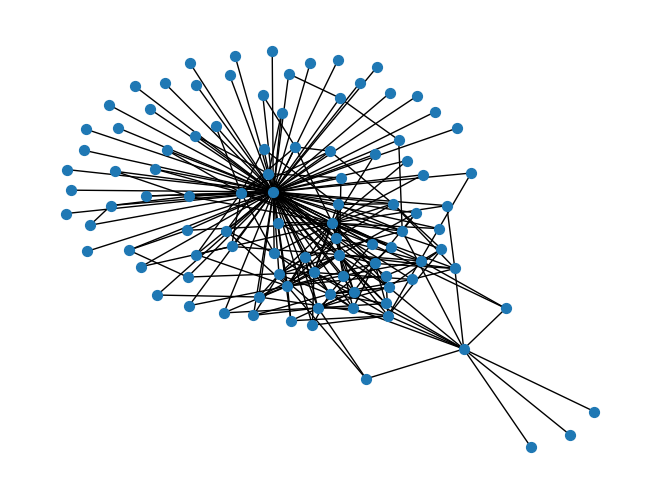

In [5]:
H = interactome_graph.subgraph(list(interactome_graph.nodes())[:100])
pos = nx.spring_layout(H)
nx.draw(H, pos, node_size=50, with_labels=False)
plt.show()

### Fetching Drug Combinations

In [3]:
from dataset_utils import load_and_merge_combinations

combinations_df = load_and_merge_combinations("./Datasets/disease_drug_combinations.tsv", diseases)

print(combinations_df.head())

  Disease ID             Drug Combination  Num Drugs  \
0   C0033578  (DB00007, DB00014, DB01128)          3   
1   C0024299           (DB00541, DB00987)          2   
2   C0024141  (DB00091, DB00860, DB01611)          3   
3   C0011849           (DB01076, DB01261)          2   
4   C0003811           (DB00661, DB04855)          2   

                    Disease Name  
0            Prostatic Neoplasms  
1                       Lymphoma  
2  Lupus Erythematosus, Systemic  
3              Diabetes Mellitus  
4             Cardiac Arrhythmia  


In [7]:
from dataset_utils import get_drug_combinations_and_unique_drugs

combos, drugs = get_drug_combinations_and_unique_drugs("Diabetes Mellitus", combinations_df)
print("Combinations for Diabetes Mellitus:", combos)
print("Unique drugs:", drugs)

Combinations for Diabetes Mellitus: [('DB01076', 'DB01261'), ('DB00678', 'DB01261'), ('DB00641', 'DB00678'), ('DB00331', 'DB00641'), ('DB00331', 'DB01261'), ('DB00412', 'DB00678'), ('DB00331', 'DB01076'), ('DB00284', 'DB00331'), ('DB00331', 'DB01261', 'DB06655'), ('DB00331', 'DB00412', 'DB01132'), ('DB01261', 'DB06655'), ('DB00678', 'DB01132'), ('DB00331', 'DB06655'), ('DB00222', 'DB00331', 'DB01132'), ('DB00284', 'DB01076'), ('DB01120', 'DB01261'), ('DB00222', 'DB00284', 'DB01261'), ('DB00222', 'DB00412'), ('DB00222', 'DB00331', 'DB00641'), ('DB00222', 'DB00331', 'DB01261'), ('DB00222', 'DB00331'), ('DB00491', 'DB01083'), ('DB00284', 'DB00331', 'DB01261'), ('DB00331', 'DB01083'), ('DB00331', 'DB01016'), ('DB00222', 'DB00331', 'DB00412'), ('DB01029', 'DB01076'), ('DB01076', 'DB01132'), ('DB01083', 'DB06655'), ('DB00222', 'DB00331', 'DB06655'), ('DB00222', 'DB00331', 'DB01076', 'DB01261'), ('DB00222', 'DB00331', 'DB01120'), ('DB00678', 'DB01120'), ('DB00222', 'DB01076'), ('DB00284', 'DB

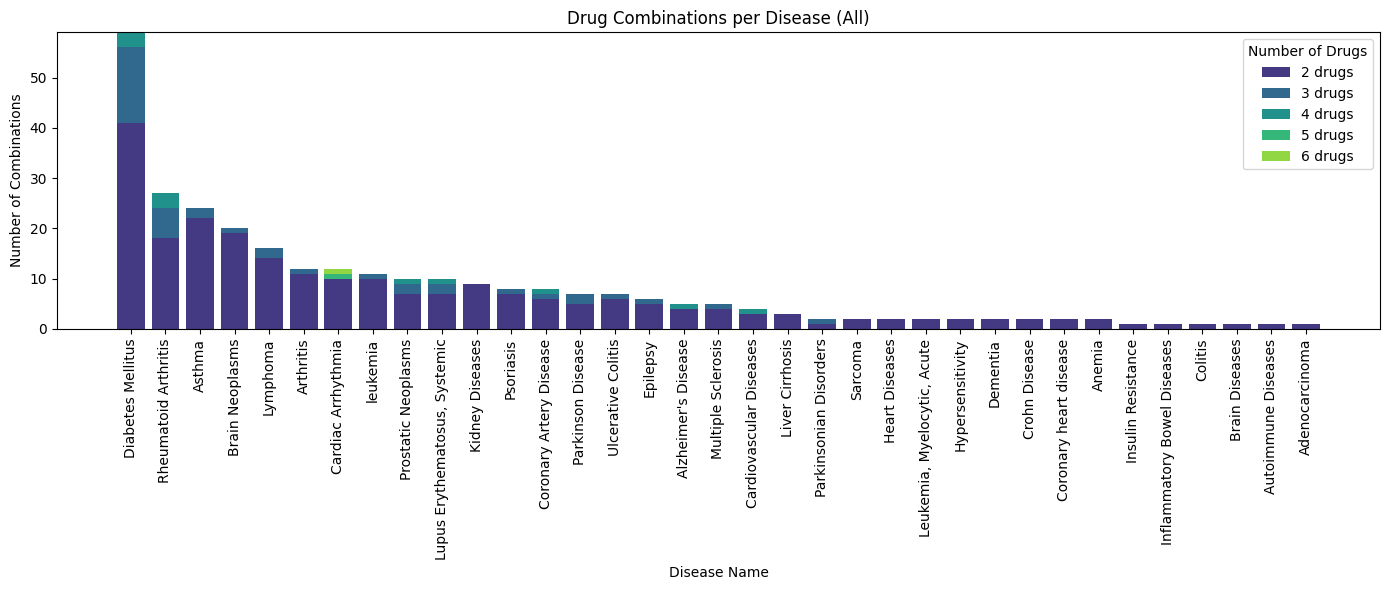

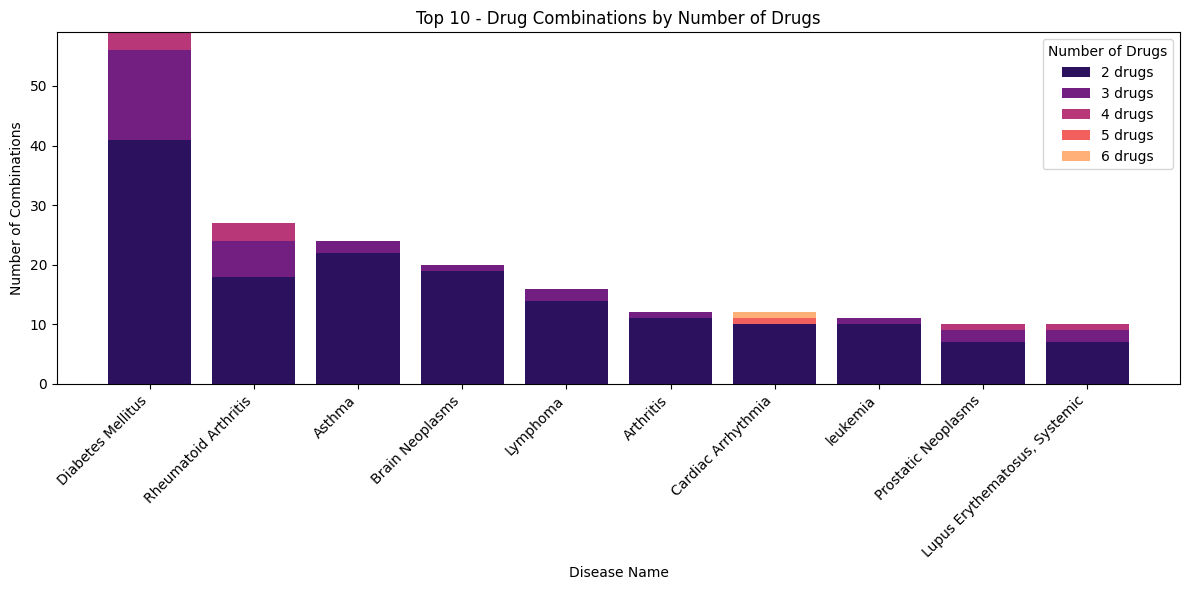

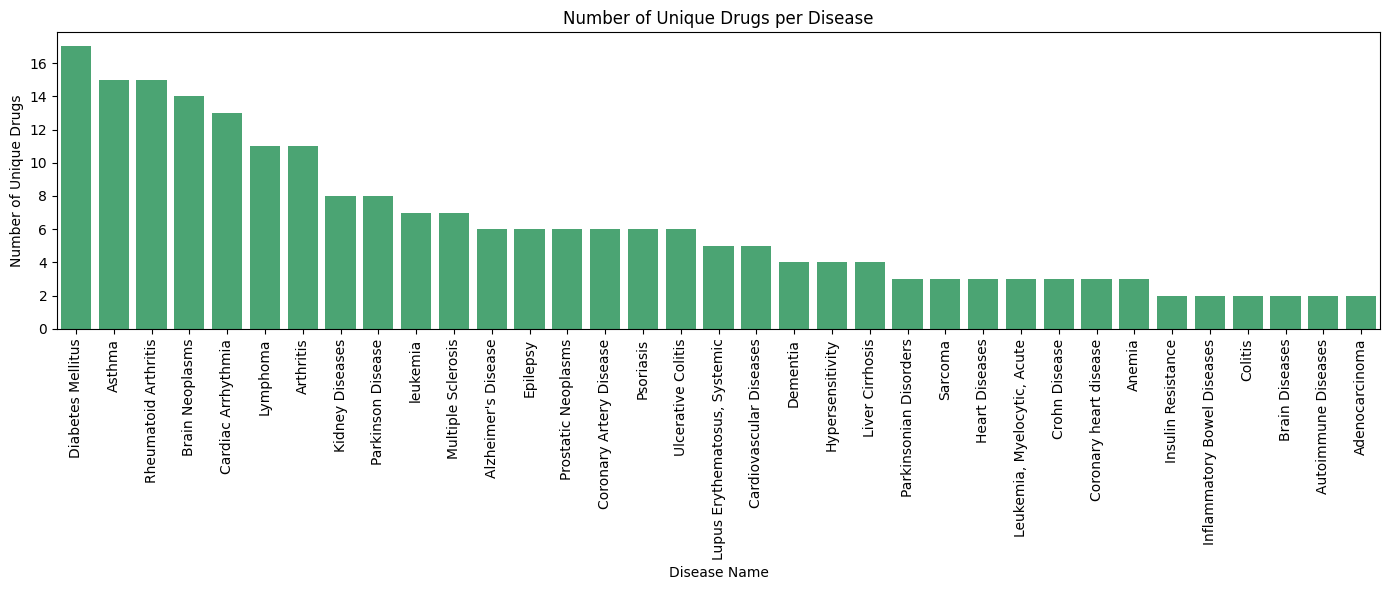

In [8]:
from dataset_utils import plot_combination_info
plot_combination_info(combinations_df)


### Precomputing All-Pairs-Shortest-Path Matrix

In [ ]:
from distance_metrics import precompute_apsp

print("Precomputing All-Pairs-Shortest-Path Matrix.")
print("This may take several minutes...")
t_i=time.time()

dist_matrix, nodes, node_to_idx = precompute_apsp(interactome_graph)

print(f"Took {time.time() - t_i:.2f} seconds to compute APSP matrix")


Precomputing All-Pairs-Shortest-Path Matrix.
This may take several minutes...
Took 812.07 seconds to compute APSP matrix


In [9]:
# Alternatively, load an aleady precomputed APSP matrix from the Results folder:

from distance_metrics import load_apsp

apsp_path = os.path.join("Results", f"apsp_data.npz")

dist_matrix, nodes, node_to_idx = load_apsp(apsp_path)

# Optimizing Hyperparameters

In [190]:
import importlib, distance_metrics, dataset_utils, qubo_selection, parameter_optimization, scaling_estimation, simulated_quantum_annealing
importlib.reload(distance_metrics)
importlib.reload(dataset_utils)
importlib.reload(qubo_selection)
importlib.reload(parameter_optimization)
importlib.reload(scaling_estimation)
importlib.reload(simulated_quantum_annealing)

<module 'simulated_quantum_annealing' from 'c:\\Users\\dmra\\Documents\\Drug-Combinations-using-Quantum-Annealers\\simulated_quantum_annealing.py'>

10
Selected drugs: ['DB00331', 'DB00412', 'DB00641', 'DB01120', 'DB00731', 'DB01016', 'DB01029', 'DB01083', 'DB01132', 'DB01261']
Best AP: 0.6759 at gamma=2.708542713567839, beta=13.241206030150753


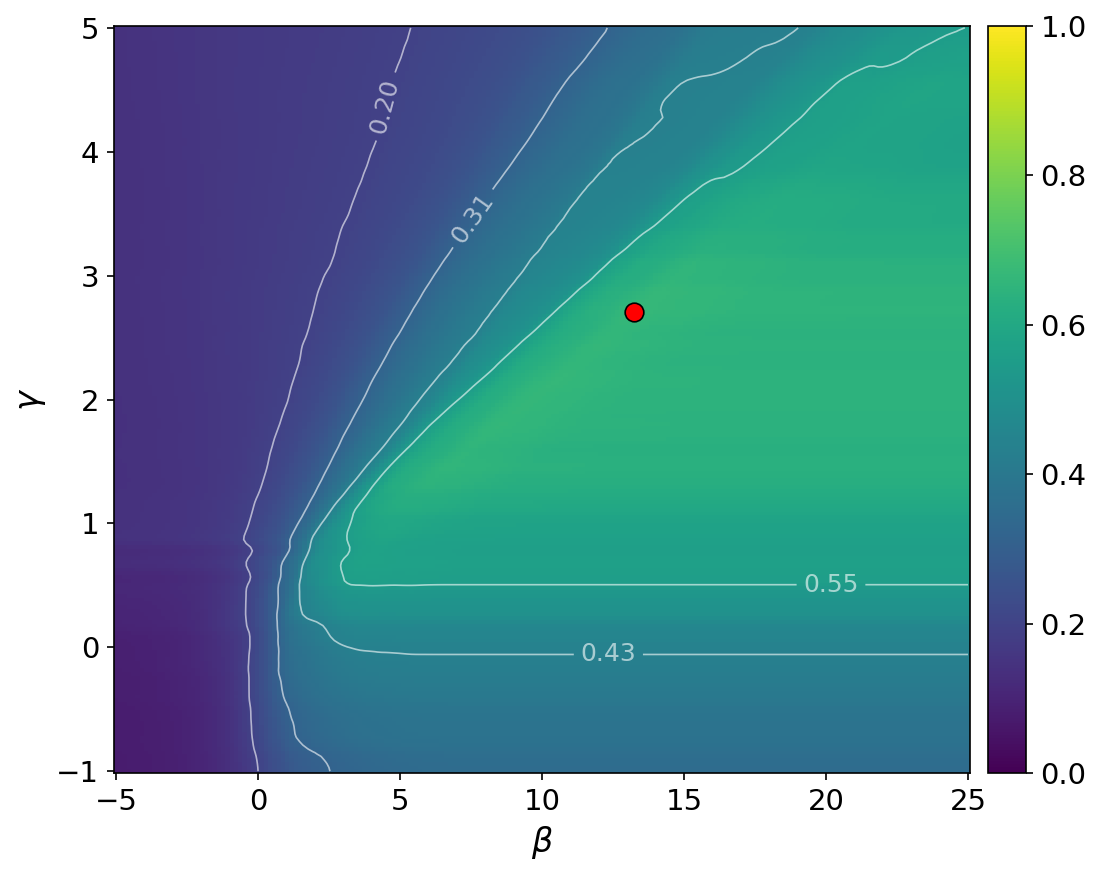

In [119]:
from parameter_optimization import optimize_for_ap, get_ground_truth_combinations, get_exact_low_energy_states, plot_metric_results
import numpy as np

disease = 'Diabetes Mellitus'
num_trials = 1 # for testing different random drug paddings if wanted 
z_score_samples = 15000  
gamma_grid = np.linspace(-1, 5, 200)
beta_grid = np.linspace(-5, 25, 200)

initial_drug_ids = ['DB00331','DB00412','DB00641','DB01120','DB00731','DB01016','DB01029','DB01083','DB01132','DB01261'] # A subset of the unique drugs in the verified combinations for this disease

num_qubits =  len(initial_drug_ids) # Use all unique drugs in the verified combinations for this disease
    
print(num_qubits)
results = optimize_for_ap(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    num_qubits=num_qubits,
    gamma_values=gamma_grid,
    beta_values=beta_grid,
    initial_drug_ids=initial_drug_ids,
    num_trials=num_trials,
    num_samples=z_score_samples
)

(best_ap_drug_ids, best_ap_score, best_ap_qubo, best_ap_gamma, best_ap_beta,
 metric_matrices, fig, ax) = results

print(f"Best AP: {best_ap_score:.4f} at gamma={best_ap_gamma}, beta={best_ap_beta}")

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

fig_path = os.path.join("Images", f"ap_landscape_{disease}.pdf")
fig.savefig(fig_path, format='pdf', bbox_inches="tight")

### Saving and Loading QUBOs

In [279]:
disease = 'Diabetes Mellitus'

disease_str = disease.replace(" ", "_")

ap_qubo_file = os.path.join("Results", f"best_ap_qubo_{disease_str}.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_ap_qubo, ap_qubo_file, compress=True)

'''
from parameter_optimization import load_qubo_from_file

best_ap_qubo = load_qubo_from_file(ap_qubo_file)

### Maximizing for Average Precision (AP)

Total relevant ground truth combinations: 18


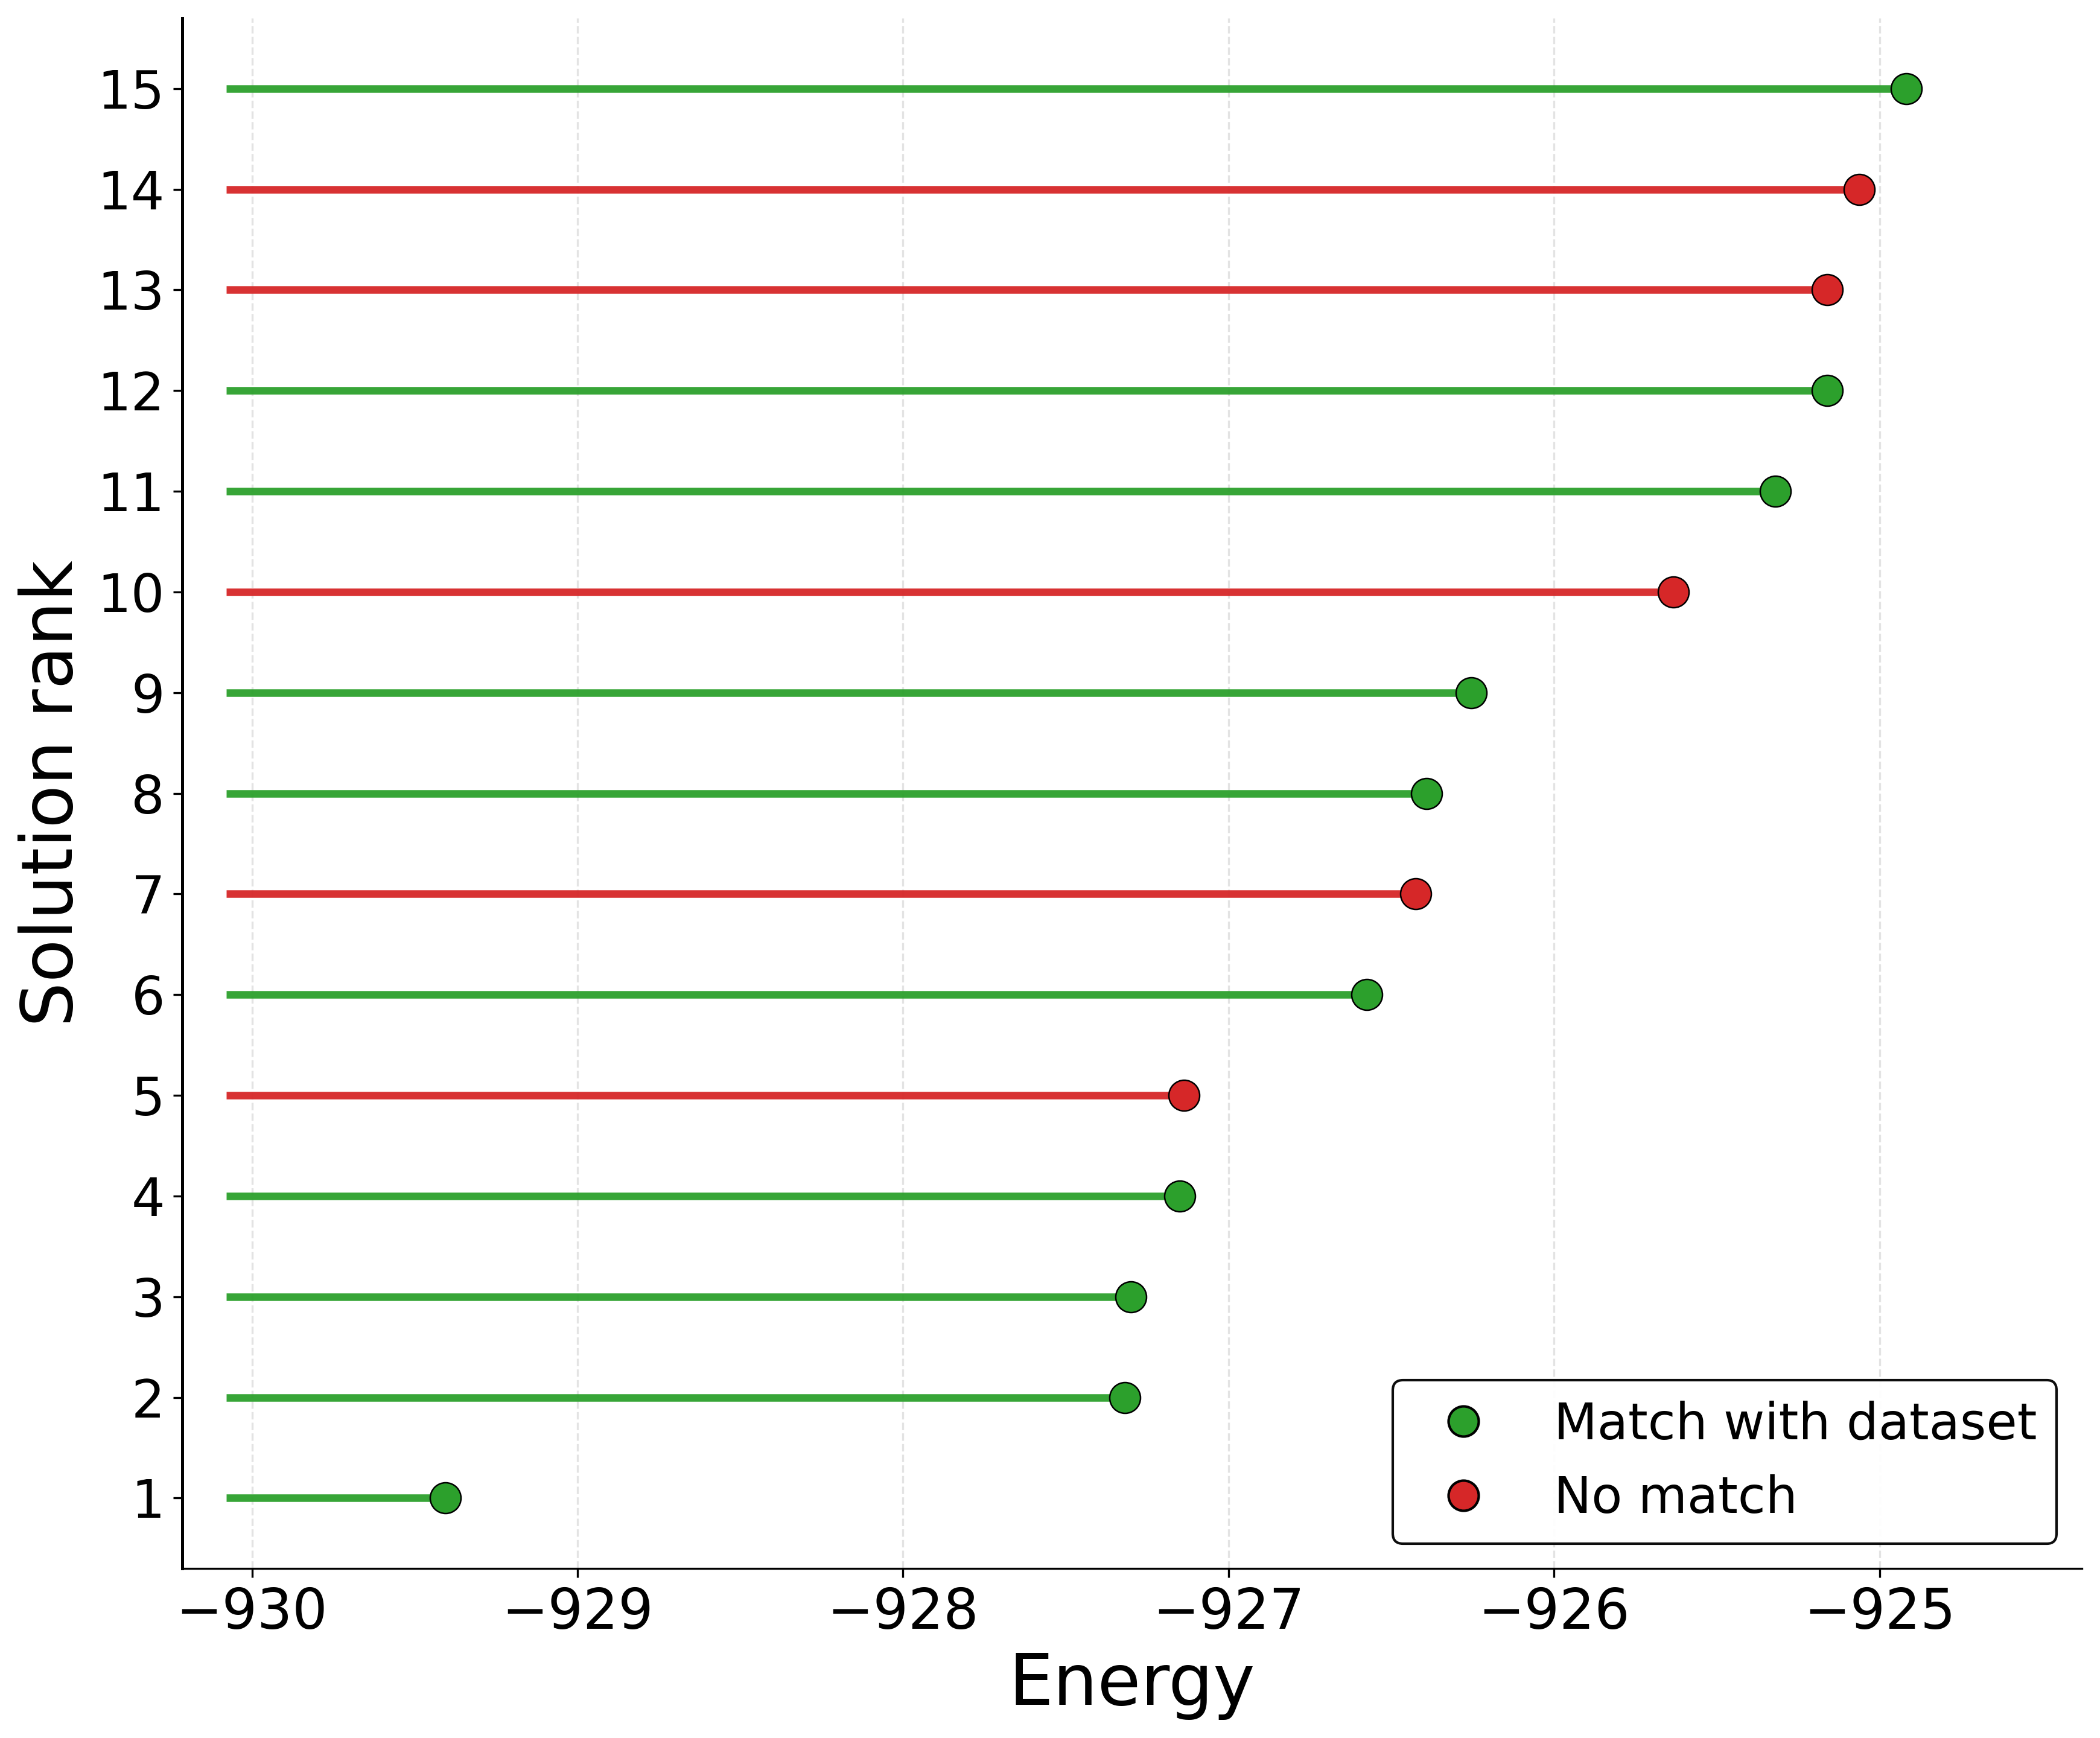

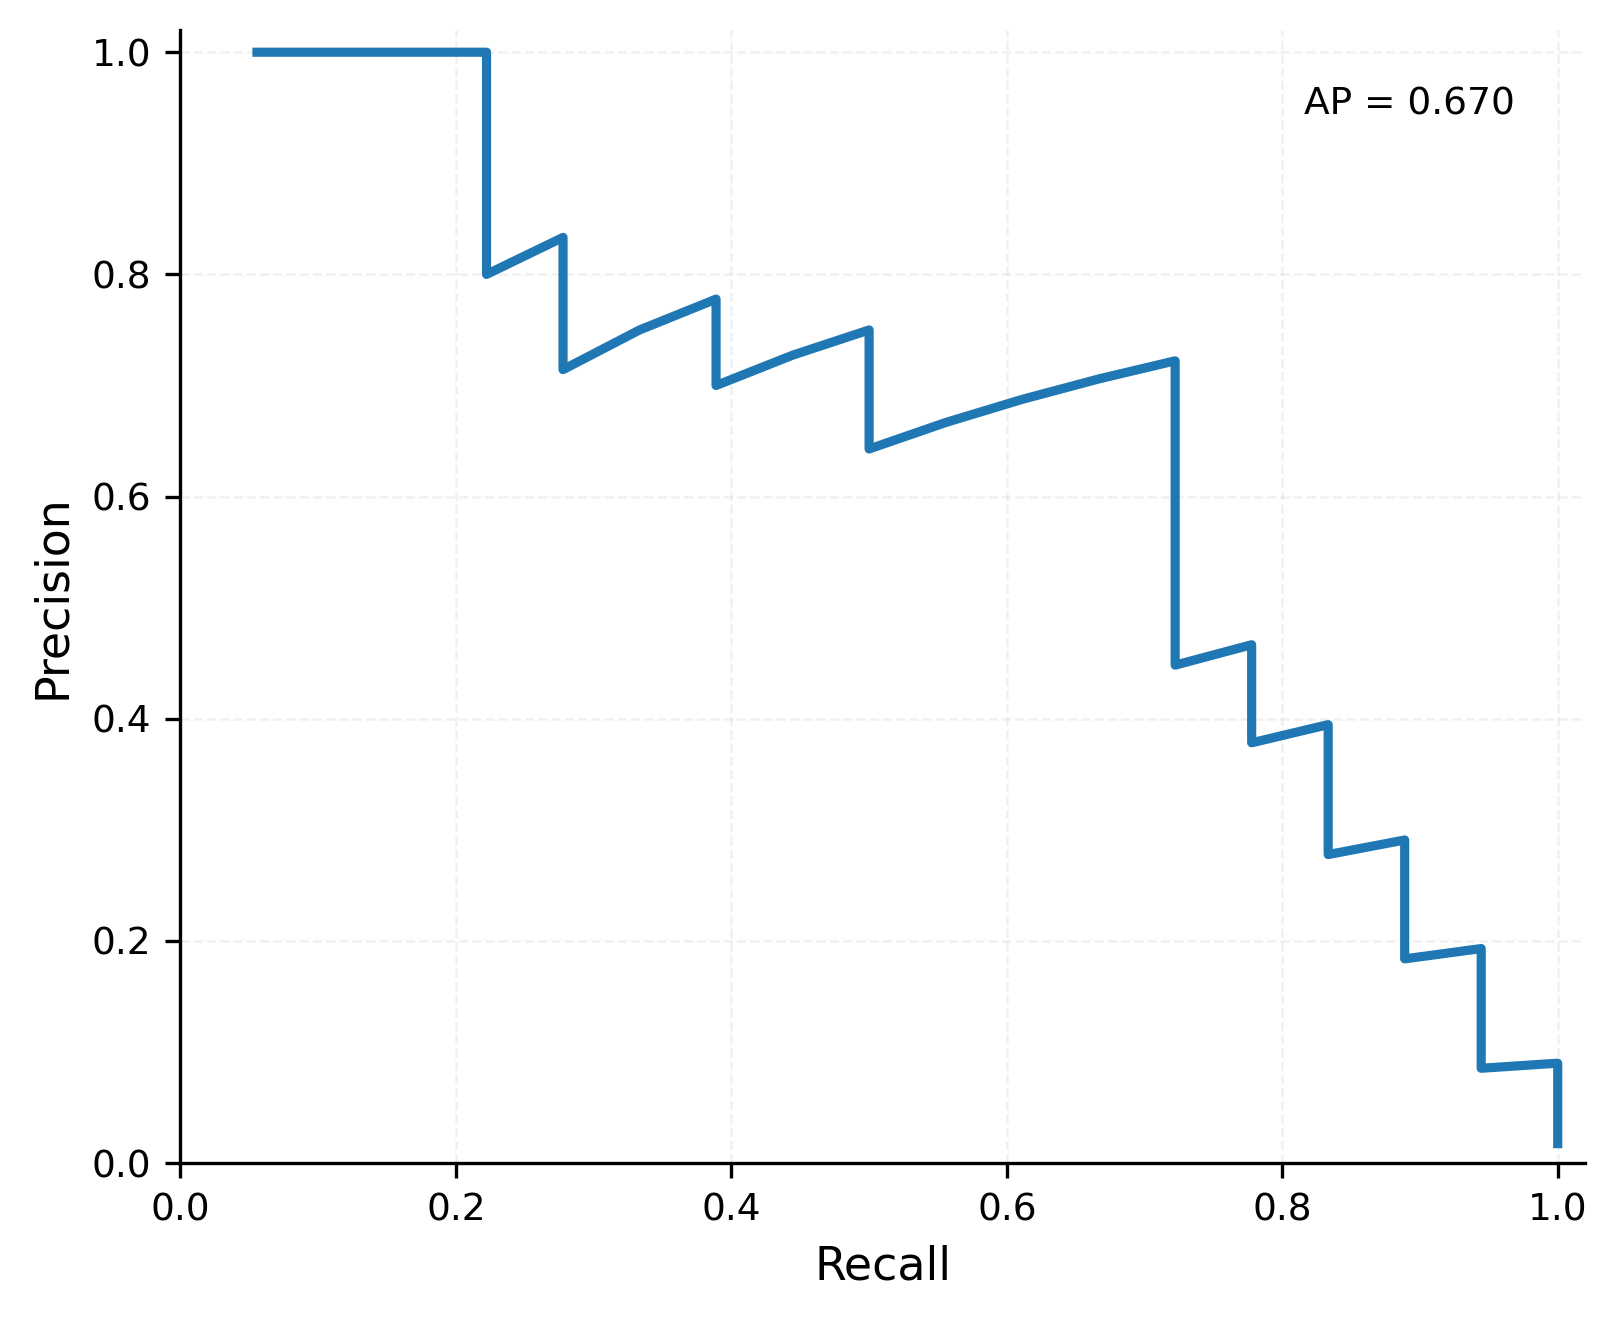

In [280]:
from parameter_optimization import plot_energy_spectrum, plot_and_compute_precision_recall_curve, get_exact_low_energy_states

best_ap_drug_ids = ['DB00331','DB00412','DB00641','DB01120','DB00731','DB01016','DB01029','DB01083','DB01132','DB01261']

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

exact_results = get_exact_low_energy_states(
    qubo=best_ap_qubo,
    drug_ids=best_ap_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      # Return up to this number of states
    energy_threshold=10000.0  # Only states within this energy of ground state
)

spectrum_fig = plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=15,
    disease_name=disease
)

sp_fig_path = os.path.join("Images", f"energy_spectrum_{disease}.pdf")
spectrum_fig.savefig(sp_fig_path, format="pdf", bbox_inches="tight")

ap, precision, recall, pr_fig = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_fig_path = os.path.join("Images", f"pr_curve_{disease}.pdf")
pr_fig.savefig(pr_fig_path, format="pdf", bbox_inches="tight")


### Scaling the number of qubits for proof of concept

50
Enumerated 20825 candidates; positives=17; AP=0.456374
 #1: energy=-999.237, pos=1, sel=('DB00331', 'DB01261')
 #2: energy=-997.218, pos=1, sel=('DB00331', 'DB00641')
 #3: energy=-997.193, pos=1, sel=('DB00331', 'DB01132')
 #4: energy=-997.001, pos=0, sel=('DB00331', 'DB01029')
 #5: energy=-996.986, pos=1, sel=('DB01132', 'DB01261')
 #6: energy=-996.456, pos=1, sel=('DB00331', 'DB00412')
 #7: energy=-996.29, pos=1, sel=('DB00331', 'DB01083')
 #8: energy=-996.261, pos=0, sel=('DB00331', 'DB08126')
 #9: energy=-996.261, pos=0, sel=('DB00331', 'DB03490')
 #10: energy=-996.25, pos=0, sel=('DB00412', 'DB01261')


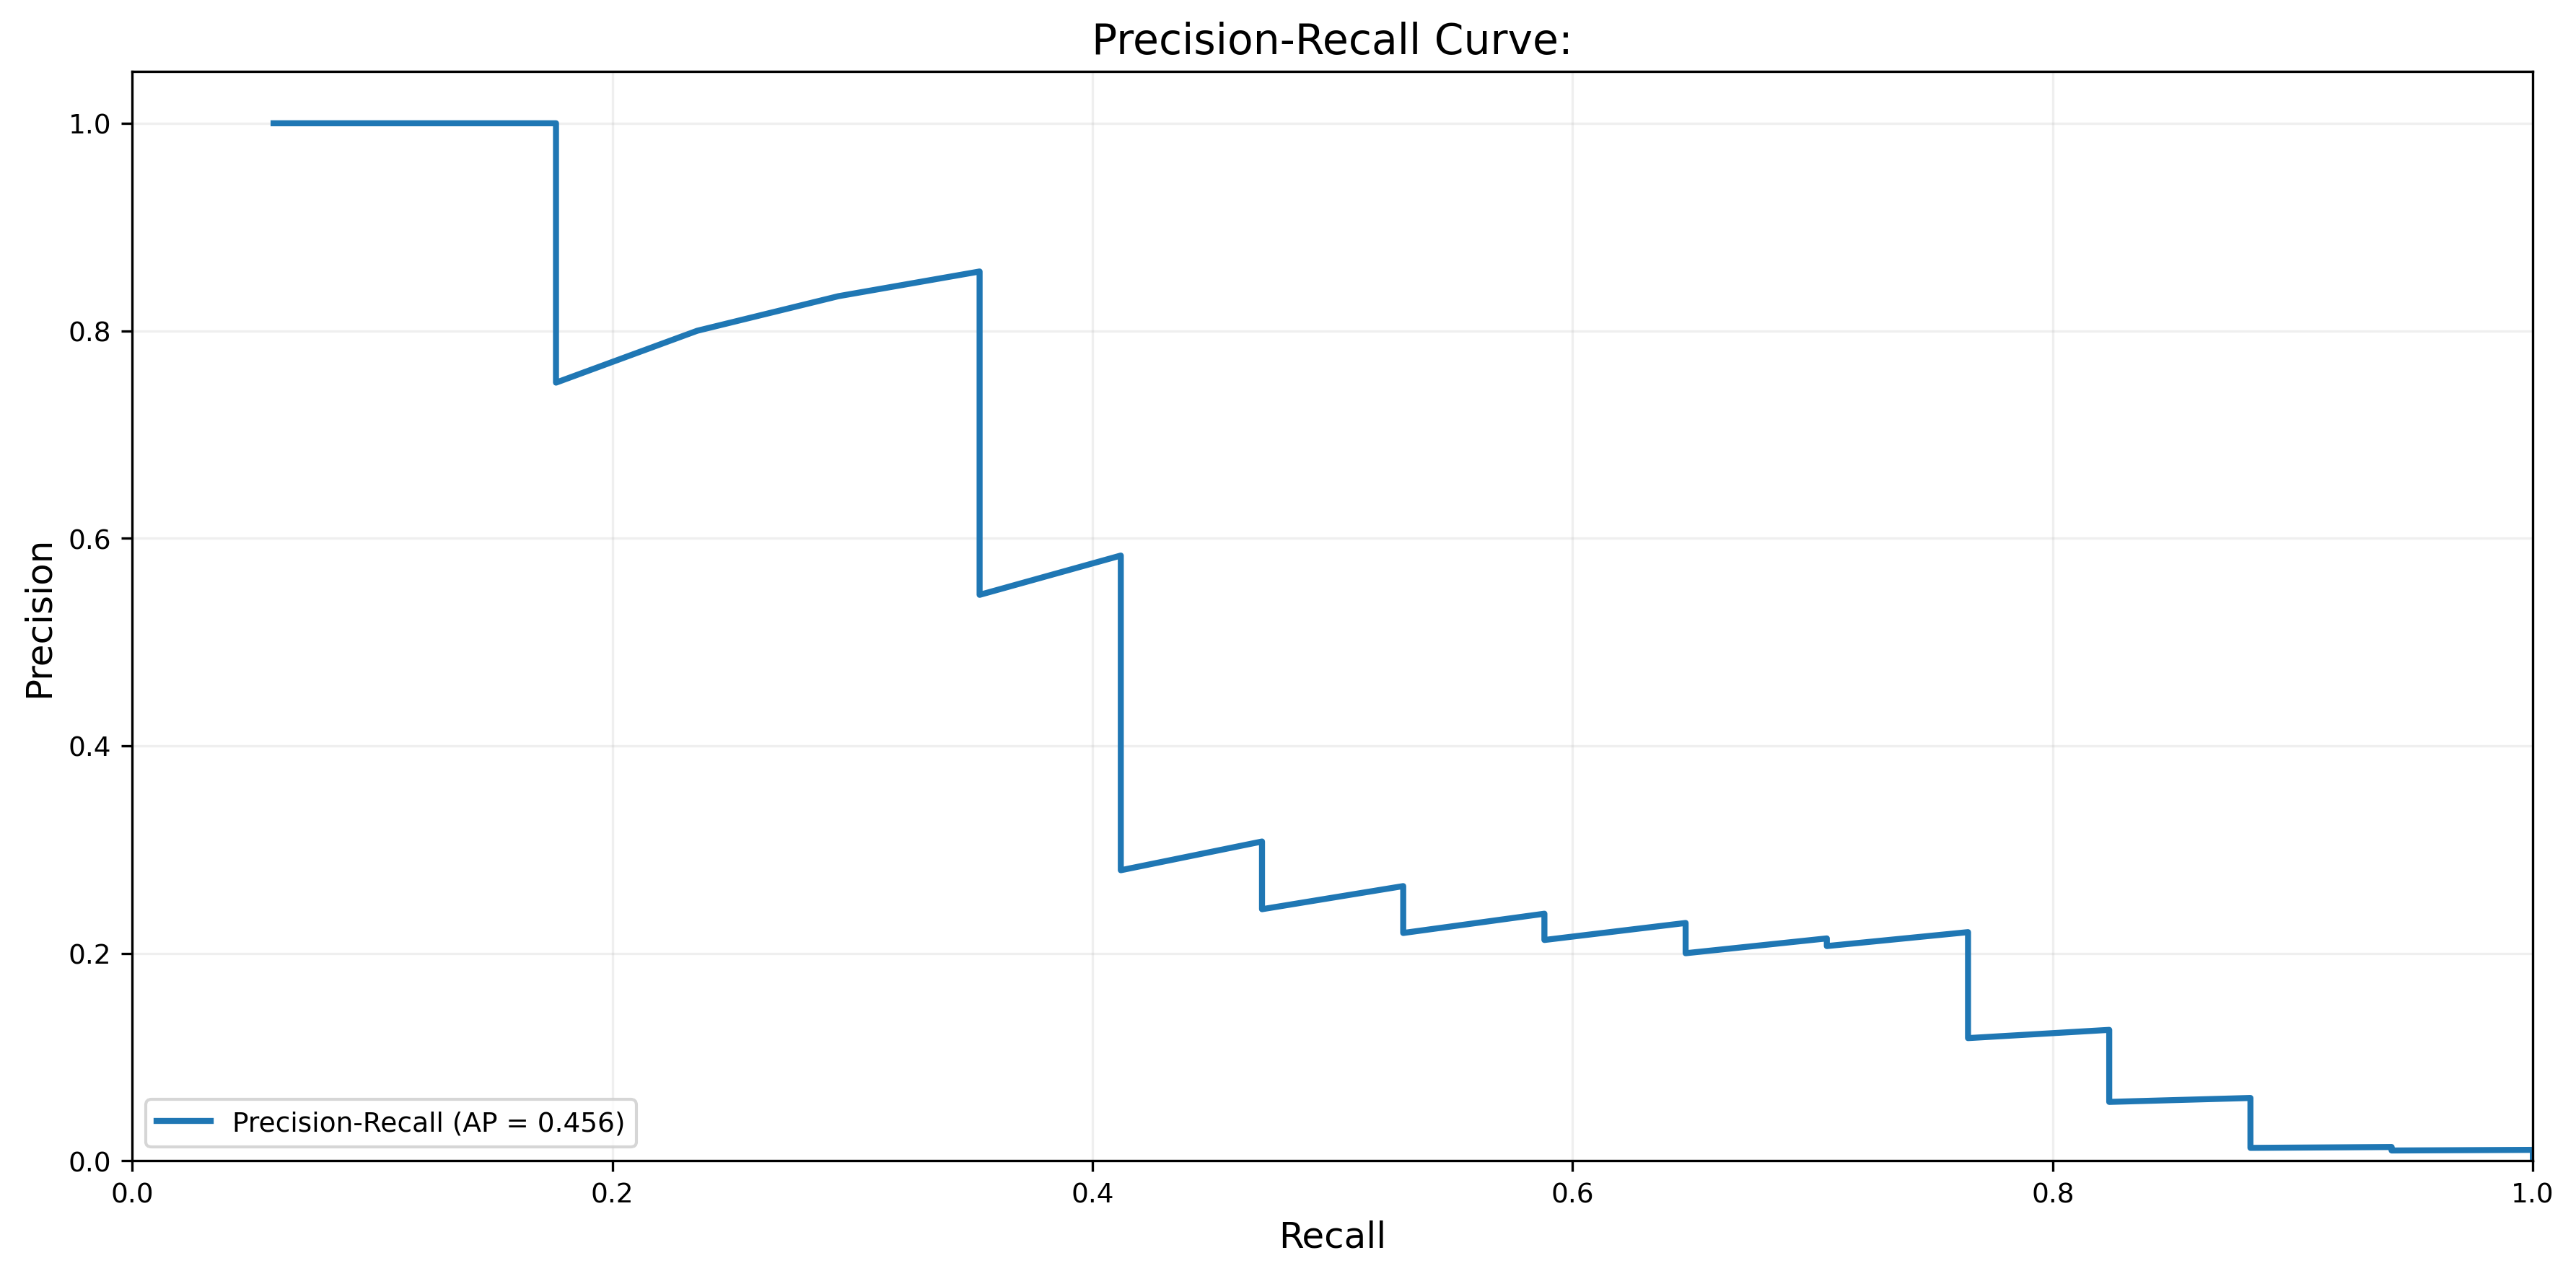

[Trial 0] ap=0.456374
Best AP: 0.45637352085478683
Best Drugs:
['DB00331', 'DB00412', 'DB00641', 'DB01120', 'DB00731', 'DB01016', 'DB01029', 'DB01083', 'DB01132', 'DB01261', 'DB08807', 'DB00268', 'DB08409', 'DB03929', 'DB04719', 'DB01245', 'DB00198', 'DB02639', 'DB08157', 'DB08756', 'DB01767', 'DB00351', 'DB07475', 'DB01291', 'DB00221', 'DB02999', 'DB00623', 'DB06196', 'DB06694', 'DB03490', 'DB00114', 'DB01065', 'DB00810', 'DB00054', 'DB00540', 'DB08403', 'DB01233', 'DB01336', 'DB04786', 'DB03448', 'DB07853', 'DB01496', 'DB00912', 'DB04590', 'DB01252', 'DB00128', 'DB07795', 'DB08126', 'DB06822', 'DB00953']


In [12]:
from qubo_selection import find_best_qubo_for_params_ap_enumeration

disease = 'Diabetes Mellitus'

#Example set of 50 drugs (10 from verified combinations, 40 random)
initial_drug_ids = ['DB00331', 'DB00412', 'DB00641', 'DB01120', 'DB00731', 'DB01016', 'DB01029', 'DB01083', 'DB01132', 'DB01261', 'DB08807', 'DB00268', 'DB08409', 'DB03929', 'DB04719', 'DB01245', 'DB00198', 'DB02639', 'DB08157', 'DB08756', 'DB01767', 'DB00351', 'DB07475', 'DB01291', 'DB00221', 'DB02999', 'DB00623', 'DB06196', 'DB06694', 'DB03490', 'DB00114', 'DB01065', 'DB00810', 'DB00054', 'DB00540', 'DB08403', 'DB01233', 'DB01336', 'DB04786', 'DB03448', 'DB07853', 'DB01496', 'DB00912', 'DB04590', 'DB01252', 'DB00128', 'DB07795', 'DB08126', 'DB06822', 'DB00953']

allowed_sizes=[2,3]
return_curve= True
best_ap_gamma = 2.739 
best_ap_beta = 13.392
num_trials = 1
z_score_samples = 20000
num_qubits = 50
print(len(initial_drug_ids))

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=initial_drug_ids,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

print("Best AP:", best_ap)
print("Best Drugs:")
print(best_drugs)

Total relevant ground truth combinations: 18


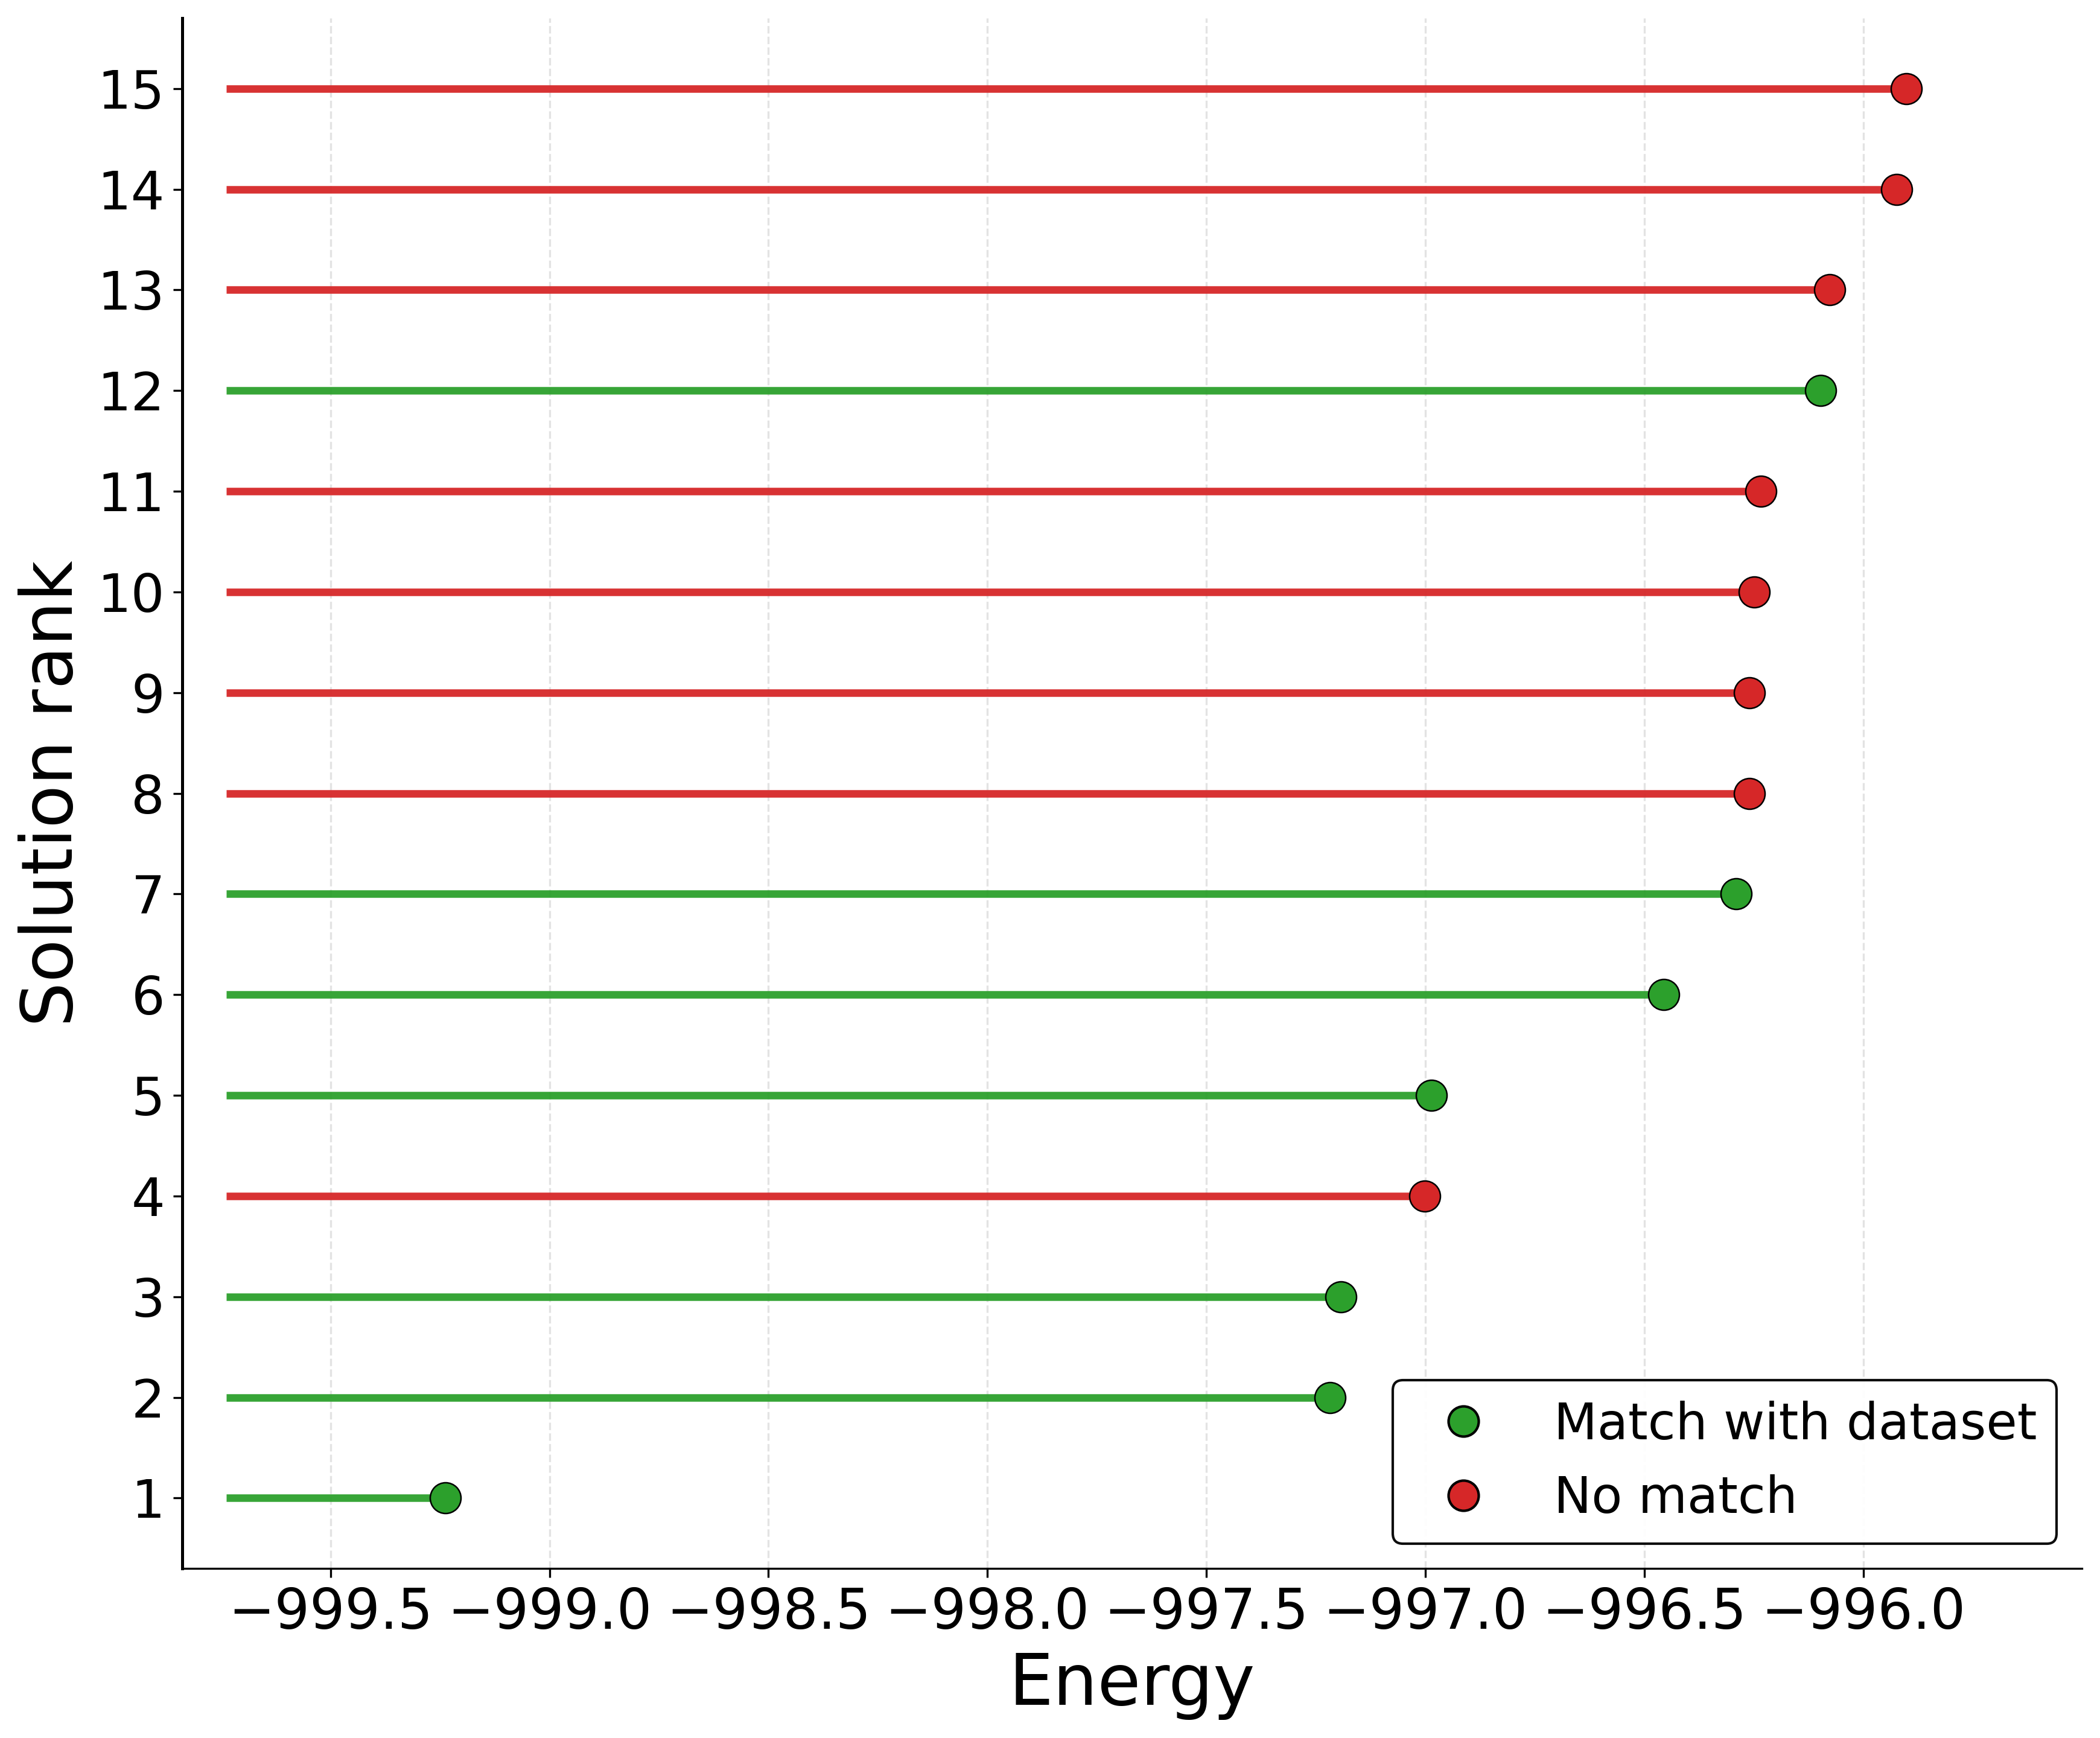

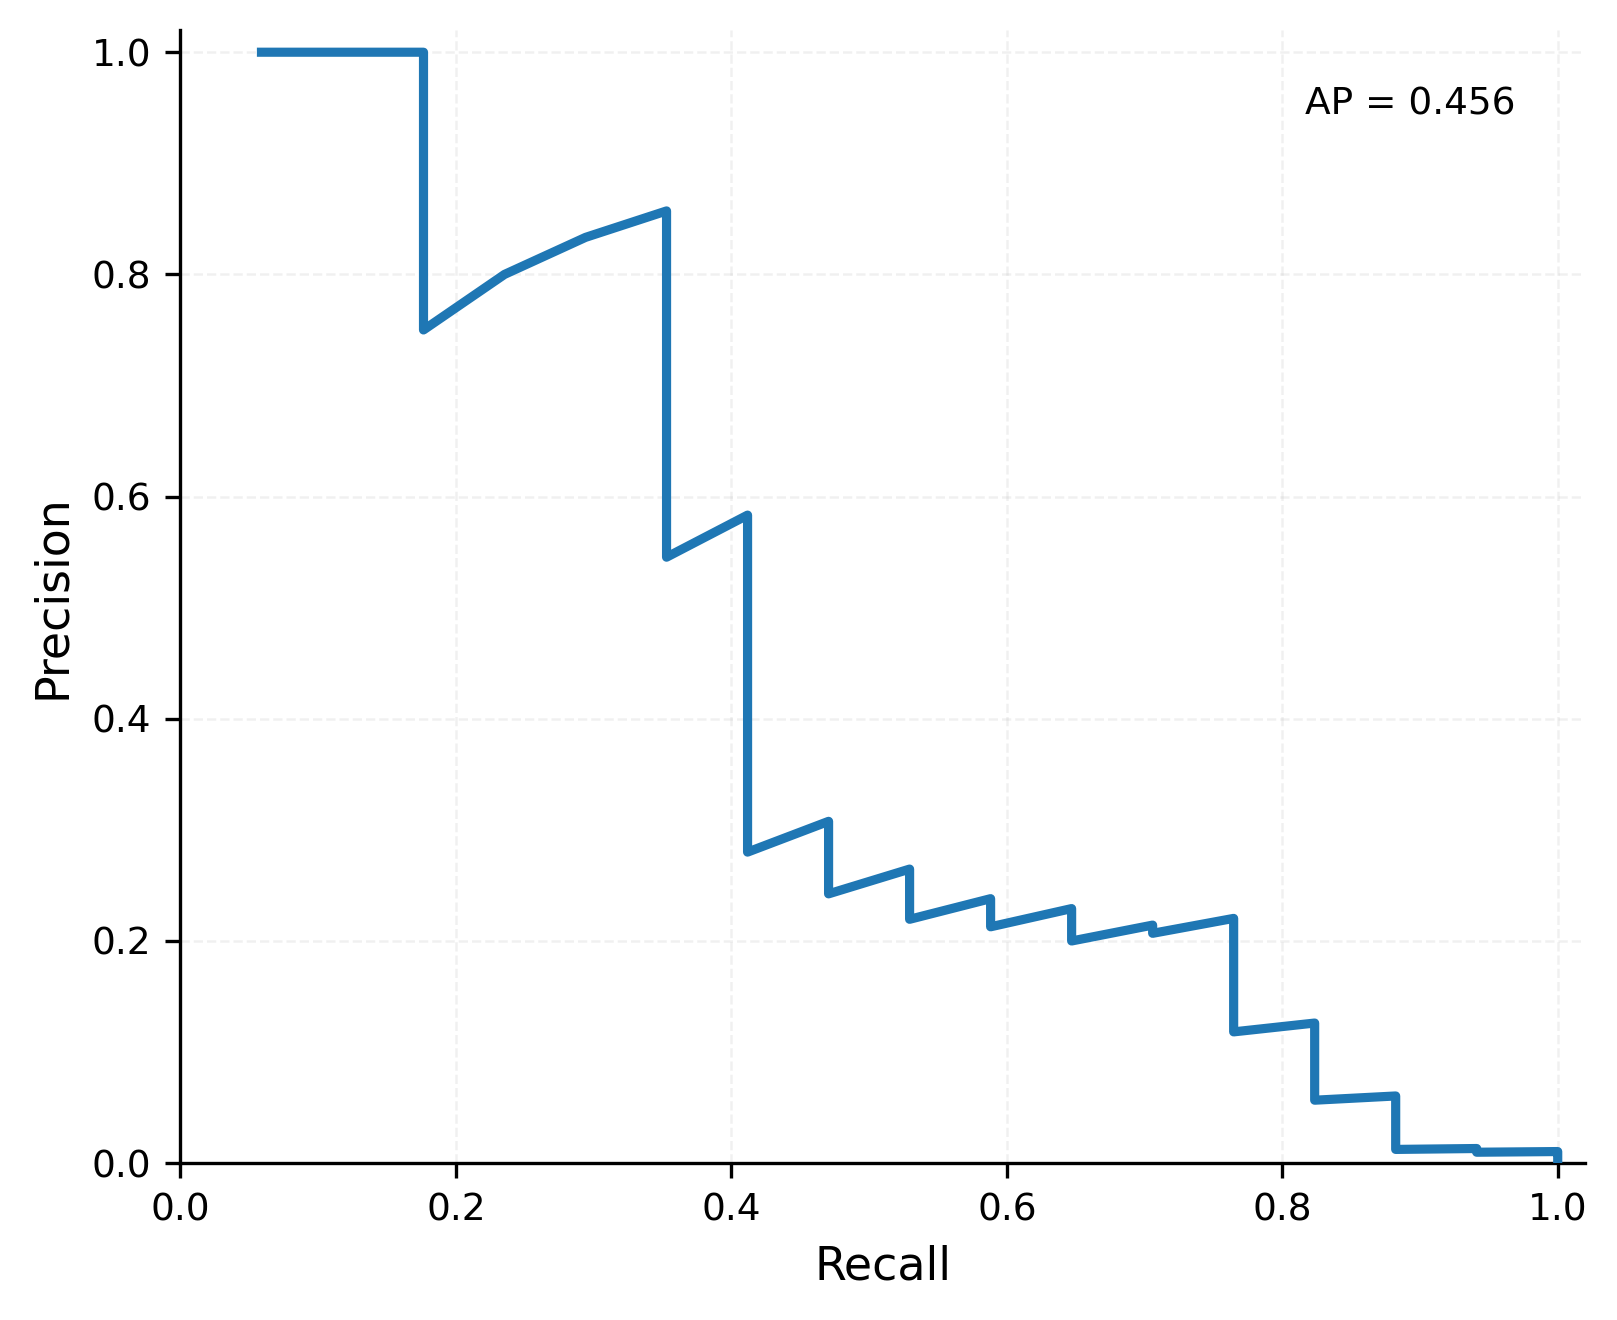

In [186]:
from qubo_selection import get_sorted_results_allowed_sizes
from parameter_optimization import plot_energy_spectrum, get_ground_truth_combinations, plot_and_compute_precision_recall_curve

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])

spectrum_50_fig = plot_energy_spectrum(sorted_results, top_n=15, disease_name=disease)

sp50_fig_path = os.path.join("Images", f"energy_spectrum_50_{disease}.pdf")

spectrum_50_fig.savefig(sp50_fig_path, format='pdf', bbox_inches="tight")

ap, precision, recall, pr_50_fig = plot_and_compute_precision_recall_curve(
    sorted_results=sorted_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_50_fig_path = os.path.join("Images", f"pr_curve_50_{disease}.pdf")
pr_50_fig.savefig(pr_50_fig_path, format="pdf", bbox_inches="tight")

In [ ]:
disease_str = disease.replace(" ", "_")

ap_qubo_file_50 = os.path.join("Results", f"best_ap_qubo_{disease}_50.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_qubo, ap_qubo_file_50, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_qubo_50 = load_qubo_from_file(ap_qubo_file_50)

Loaded QUBO matches saved QUBO: True


## Disease #2 - Brain Neoplasms

9
Selected drugs: ['DB00361', 'DB00014', 'DB00445', 'DB00603', 'DB00675', 'DB00783', 'DB01006', 'DB01101', 'DB01248']
Best AP: 0.5281 at gamma=4.595317725752508, beta=34.381270903010034


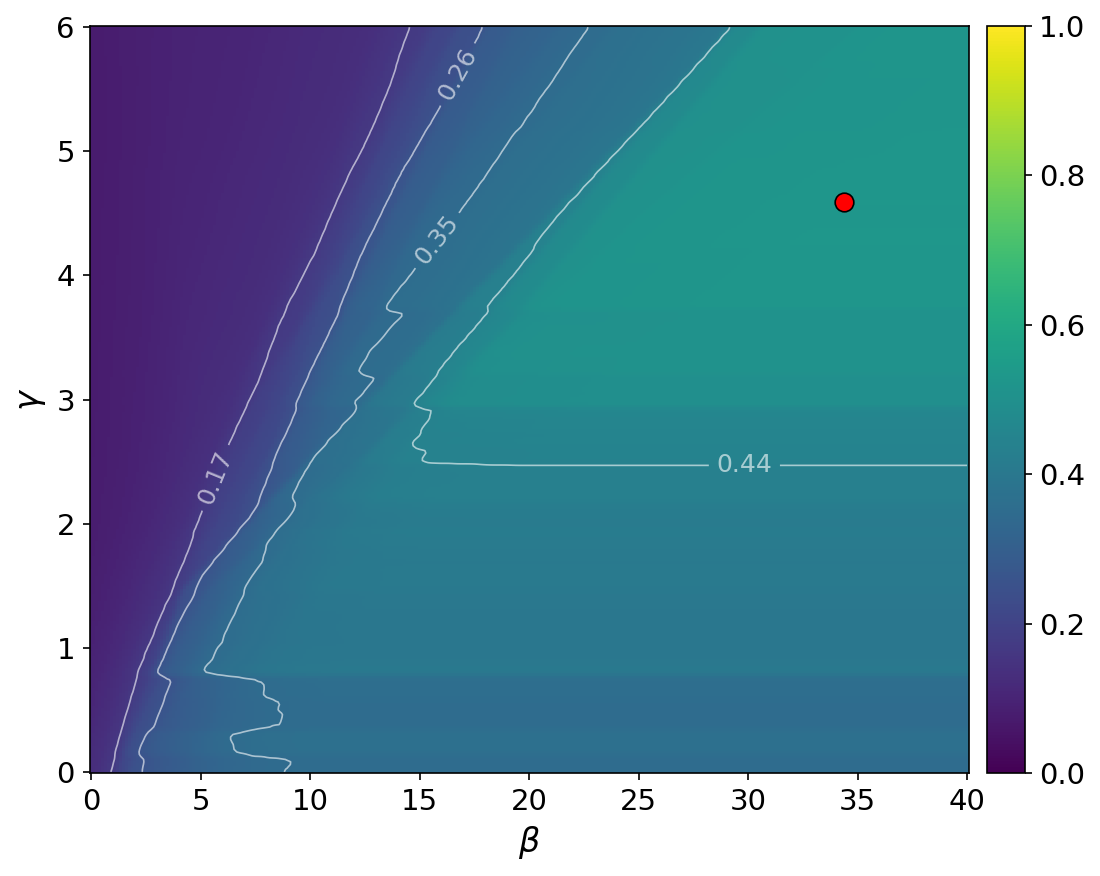

In [ ]:
from parameter_optimization import optimize_for_ap, get_ground_truth_combinations, get_exact_low_energy_states, plot_metric_results
import numpy as np

disease = 'Brain Neoplasms'
num_trials = 1 # for testing different random drug paddings if wanted 
z_score_samples = 15000  
gamma_grid = np.linspace(0, 6, 300)
beta_grid = np.linspace(0, 40, 300)

initial_drug_ids_2 = ['DB00361','DB00014','DB00445','DB00603','DB00675','DB00783','DB01006','DB01101','DB01248']# A subset of the unique drugs in the verified combinations for this disease

num_qubits_2 =  len(initial_drug_ids_2) # Use all unique drugs in the verified combinations for this disease
    
print(num_qubits_2)
results = optimize_for_ap(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    num_qubits=num_qubits_2,
    gamma_values=gamma_grid,
    beta_values=beta_grid,
    initial_drug_ids=initial_drug_ids_2,
    num_trials=num_trials,
    num_samples=z_score_samples
)

(best_ap_drug_ids, best_ap_score, best_ap_qubo, best_ap_gamma, best_ap_beta,
 metric_matrices, fig, ax) = results

print(f"Best AP: {best_ap_score:.4f} at gamma={best_ap_gamma}, beta={best_ap_beta}")

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

fig_path = os.path.join("Images", f"ap_landscape_{disease}.pdf")
fig.savefig(fig_path, format='pdf', bbox_inches="tight")

In [272]:
disease = 'Brain Neoplasms'

disease_str = disease.replace(" ", "_")

ap_qubo_file = os.path.join("Results", f"best_ap_qubo_{disease_str}.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_ap_qubo, ap_qubo_file, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_ap_qubo = load_qubo_from_file(ap_qubo_file)

Total relevant ground truth combinations: 12


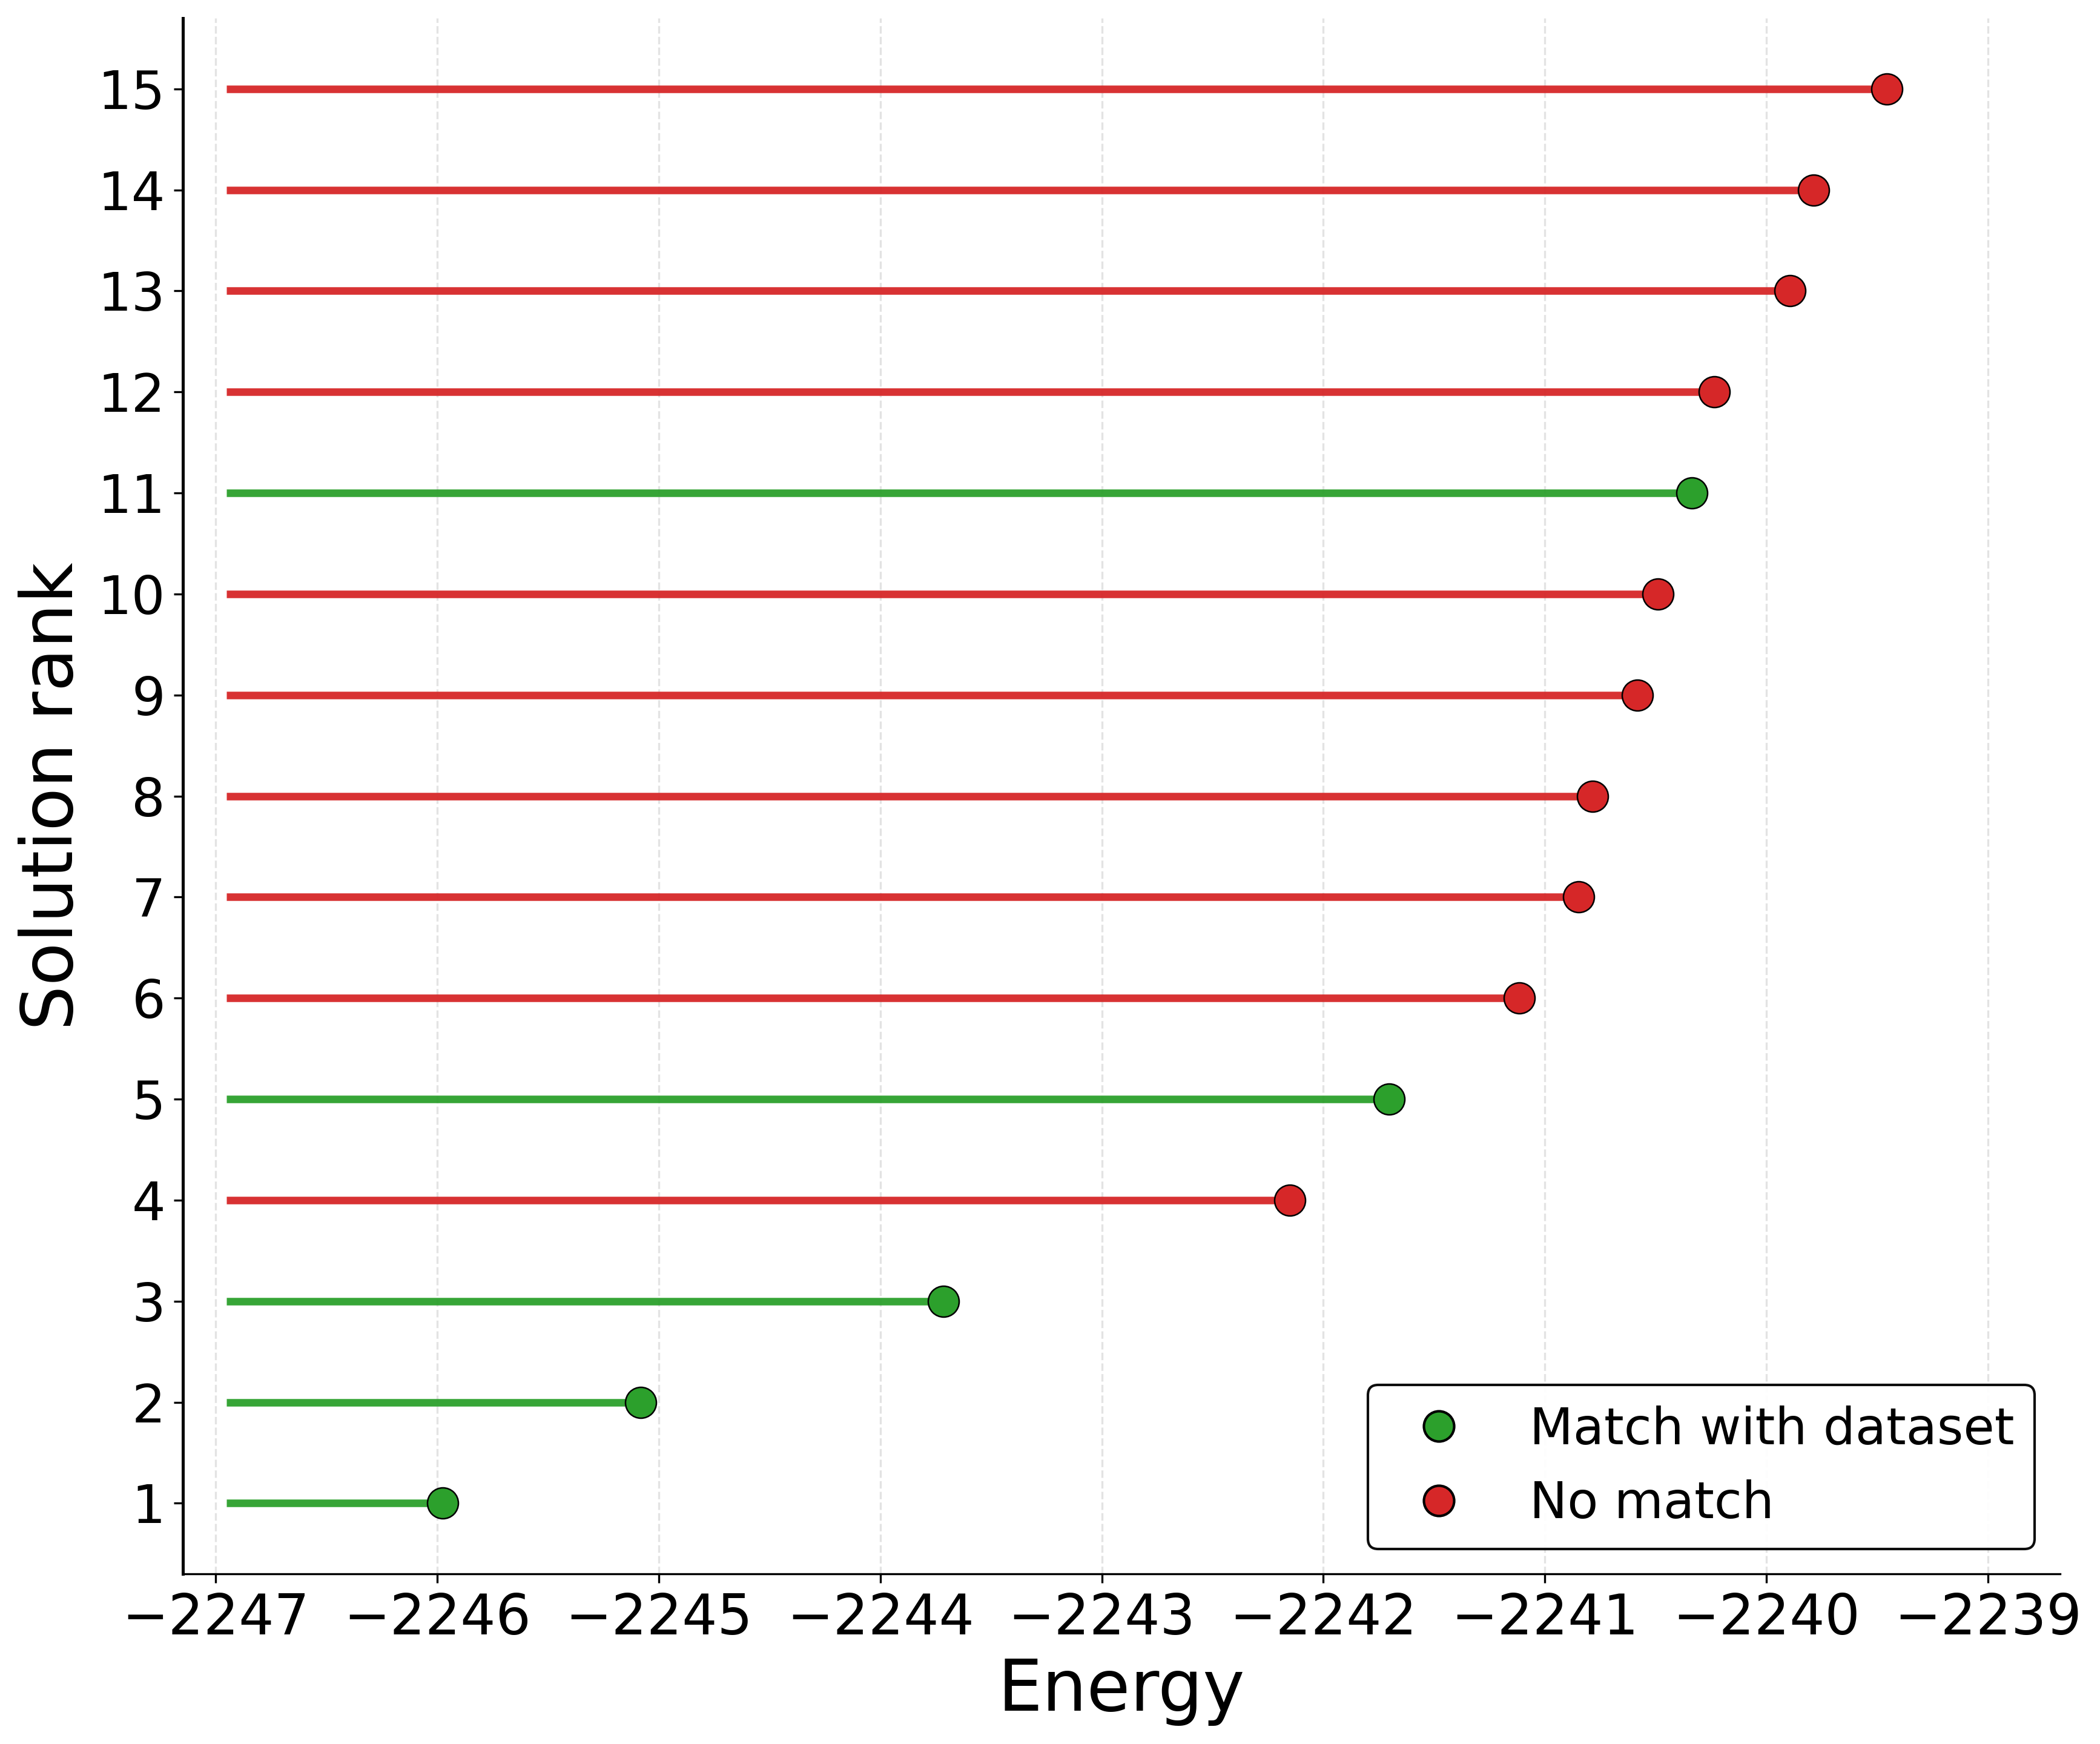

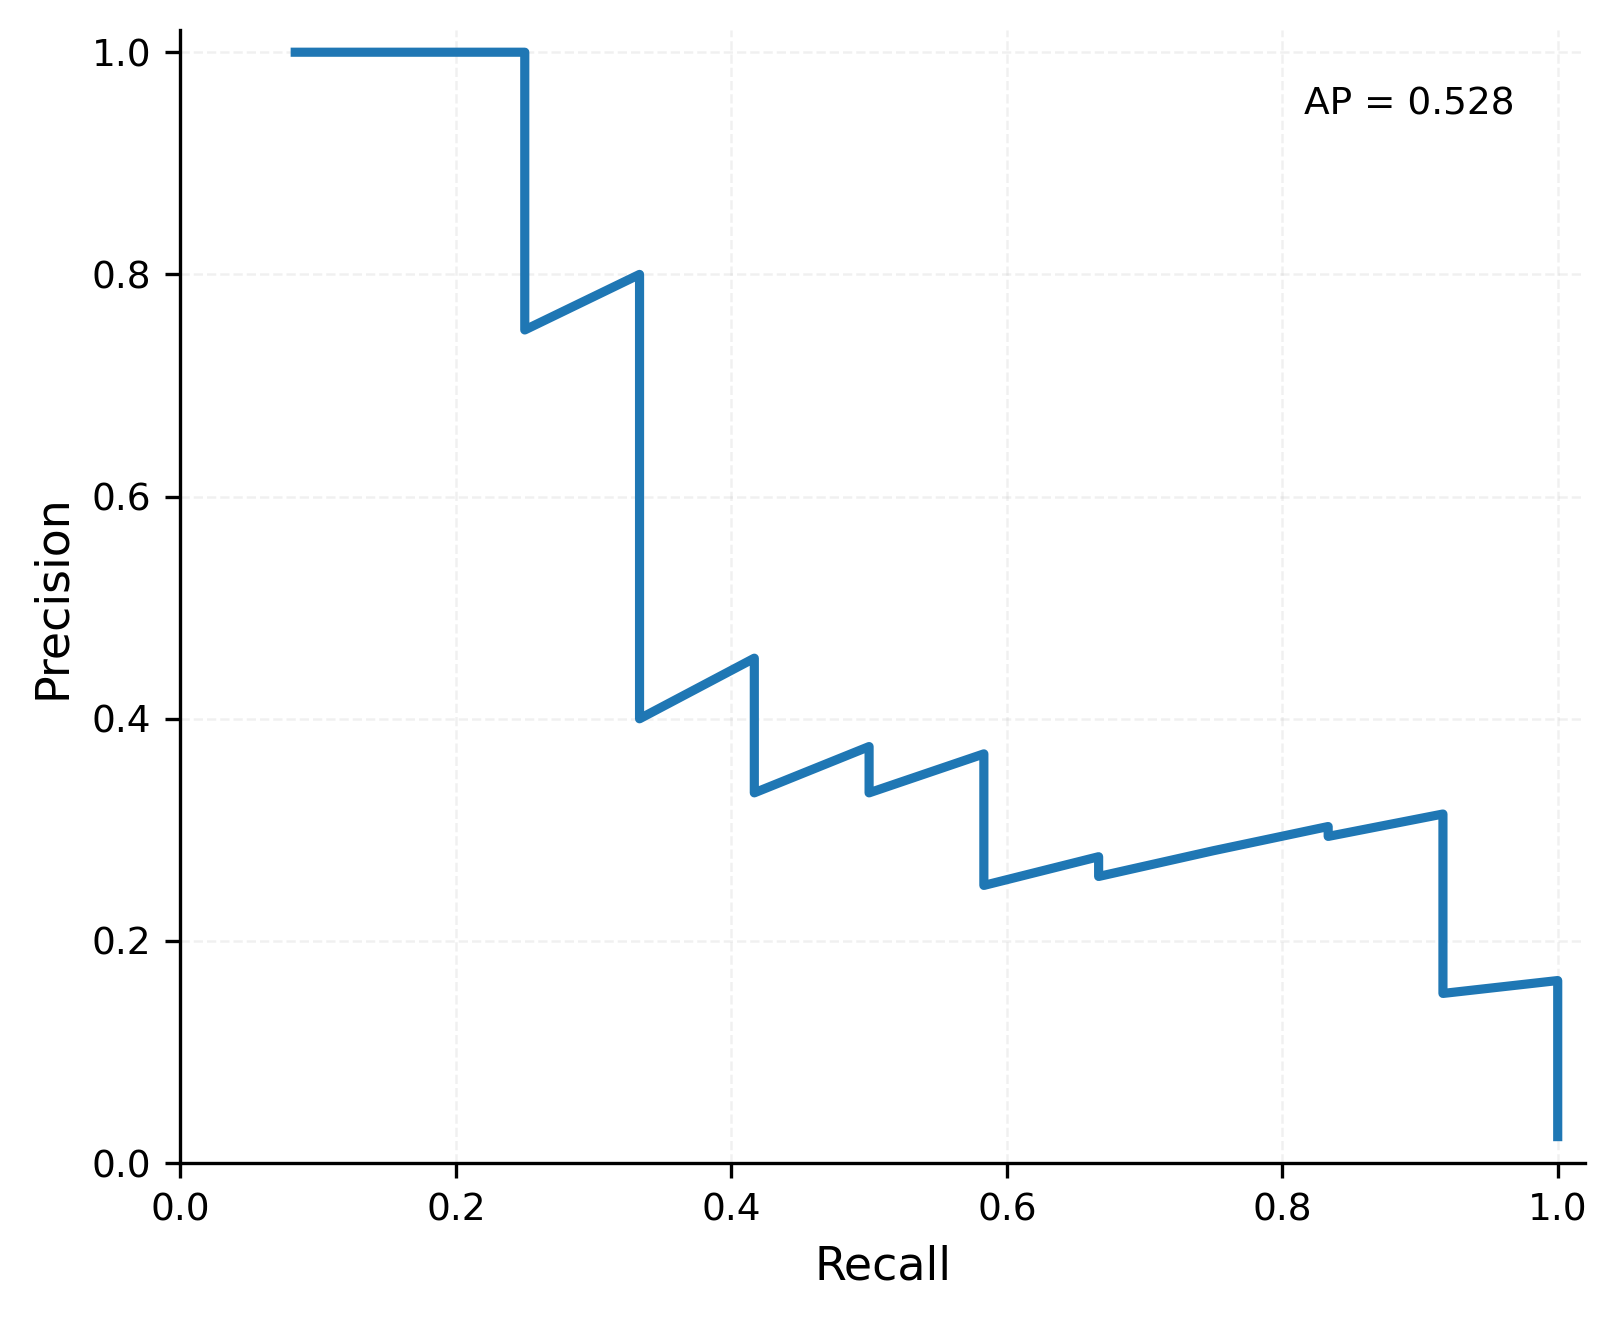

In [275]:
from parameter_optimization import plot_energy_spectrum, plot_and_compute_precision_recall_curve, get_exact_low_energy_states

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

best_ap_drug_ids = ['DB00361','DB00014','DB00445','DB00603','DB00675','DB00783','DB01006','DB01101','DB01248']

exact_results = get_exact_low_energy_states(
    qubo=best_ap_qubo,
    drug_ids=best_ap_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      # Return up to this number of states
    energy_threshold=10000.0  # Only states within this energy of ground state
)

spectrum_fig = plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=15,
    disease_name=disease
)

sp_fig_path = os.path.join("Images", f"energy_spectrum_{disease}.pdf")
spectrum_fig.savefig(sp_fig_path, format="pdf", bbox_inches="tight")

ap, precision, recall, pr_fig = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_fig_path = os.path.join("Images", f"pr_curve_{disease}.pdf")
pr_fig.savefig(pr_fig_path, format="pdf", bbox_inches="tight")


In [262]:
from qubo_selection import find_best_qubo_for_params_ap_enumeration

disease = 'Brain Neoplasms'

#Example set of 50 drugs (9 from verified combinations, 41 random)
initial_drug_ids = ['DB00361', 'DB00014', 'DB00445', 'DB00603', 'DB00675', 'DB00783', 'DB01006', 'DB01101', 'DB01248', 'DB01135', 'DB08653', 'DB01339', 'DB07886', 'DB06196', 'DB00246', 'DB01003', 'DB00731', 'DB00382', 'DB01285', 'DB02459', 'DB00321', 'DB02721', 'DB00878', 'DB03535', 'DB00477', 'DB01200', 'DB01528', 'DB08612', 'DB02763', 'DB01628', 'DB00182', 'DB00381', 'DB04842', 'DB07790', 'DB00363', 'DB00589', 'DB00598', 'DB04794', 'DB01267', 'DB00393', 'DB00420', 'DB00762', 'DB01159', 'DB01287', 'DB01288', 'DB06834', 'DB01064', 'DB08429', 'DB00370', 'DB01351']


allowed_sizes=[2,3]
return_curve= False
best_ap_gamma = 4.595
best_ap_beta = 34.381
num_trials = 1
z_score_samples = 4000
num_qubits = 50
print(len(initial_drug_ids))

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=initial_drug_ids,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

print("Best AP:", best_ap)
print("Best Drugs:")
print(best_drugs) 

50
Enumerated 20825 candidates; positives=12; AP=0.376473
 #1: energy=-2242.23, pos=1, sel=('DB00361', 'DB01101')
 #2: energy=-2241.39, pos=1, sel=('DB00361', 'DB01006')
 #3: energy=-2240.07, pos=1, sel=('DB01006', 'DB01101')
 #4: energy=-2238.41, pos=0, sel=('DB00361', 'DB00445')
 #5: energy=-2237.91, pos=1, sel=('DB00361', 'DB01248')
 #6: energy=-2237.35, pos=0, sel=('DB00361', 'DB00675')
 #7: energy=-2237.13, pos=0, sel=('DB00603', 'DB01101')
 #8: energy=-2237.1, pos=0, sel=('DB01101', 'DB01351')
 #9: energy=-2237.09, pos=0, sel=('DB00445', 'DB01101')
 #10: energy=-2236.86, pos=0, sel=('DB00675', 'DB01101')
[Trial 0] ap=0.376473
Best AP: 0.3764734362346214
Best Drugs:
['DB00361', 'DB00014', 'DB00445', 'DB00603', 'DB00675', 'DB00783', 'DB01006', 'DB01101', 'DB01248', 'DB01135', 'DB08653', 'DB01339', 'DB07886', 'DB06196', 'DB00246', 'DB01003', 'DB00731', 'DB00382', 'DB01285', 'DB02459', 'DB00321', 'DB02721', 'DB00878', 'DB03535', 'DB00477', 'DB01200', 'DB01528', 'DB08612', 'DB02763', 

Total relevant ground truth combinations: 12


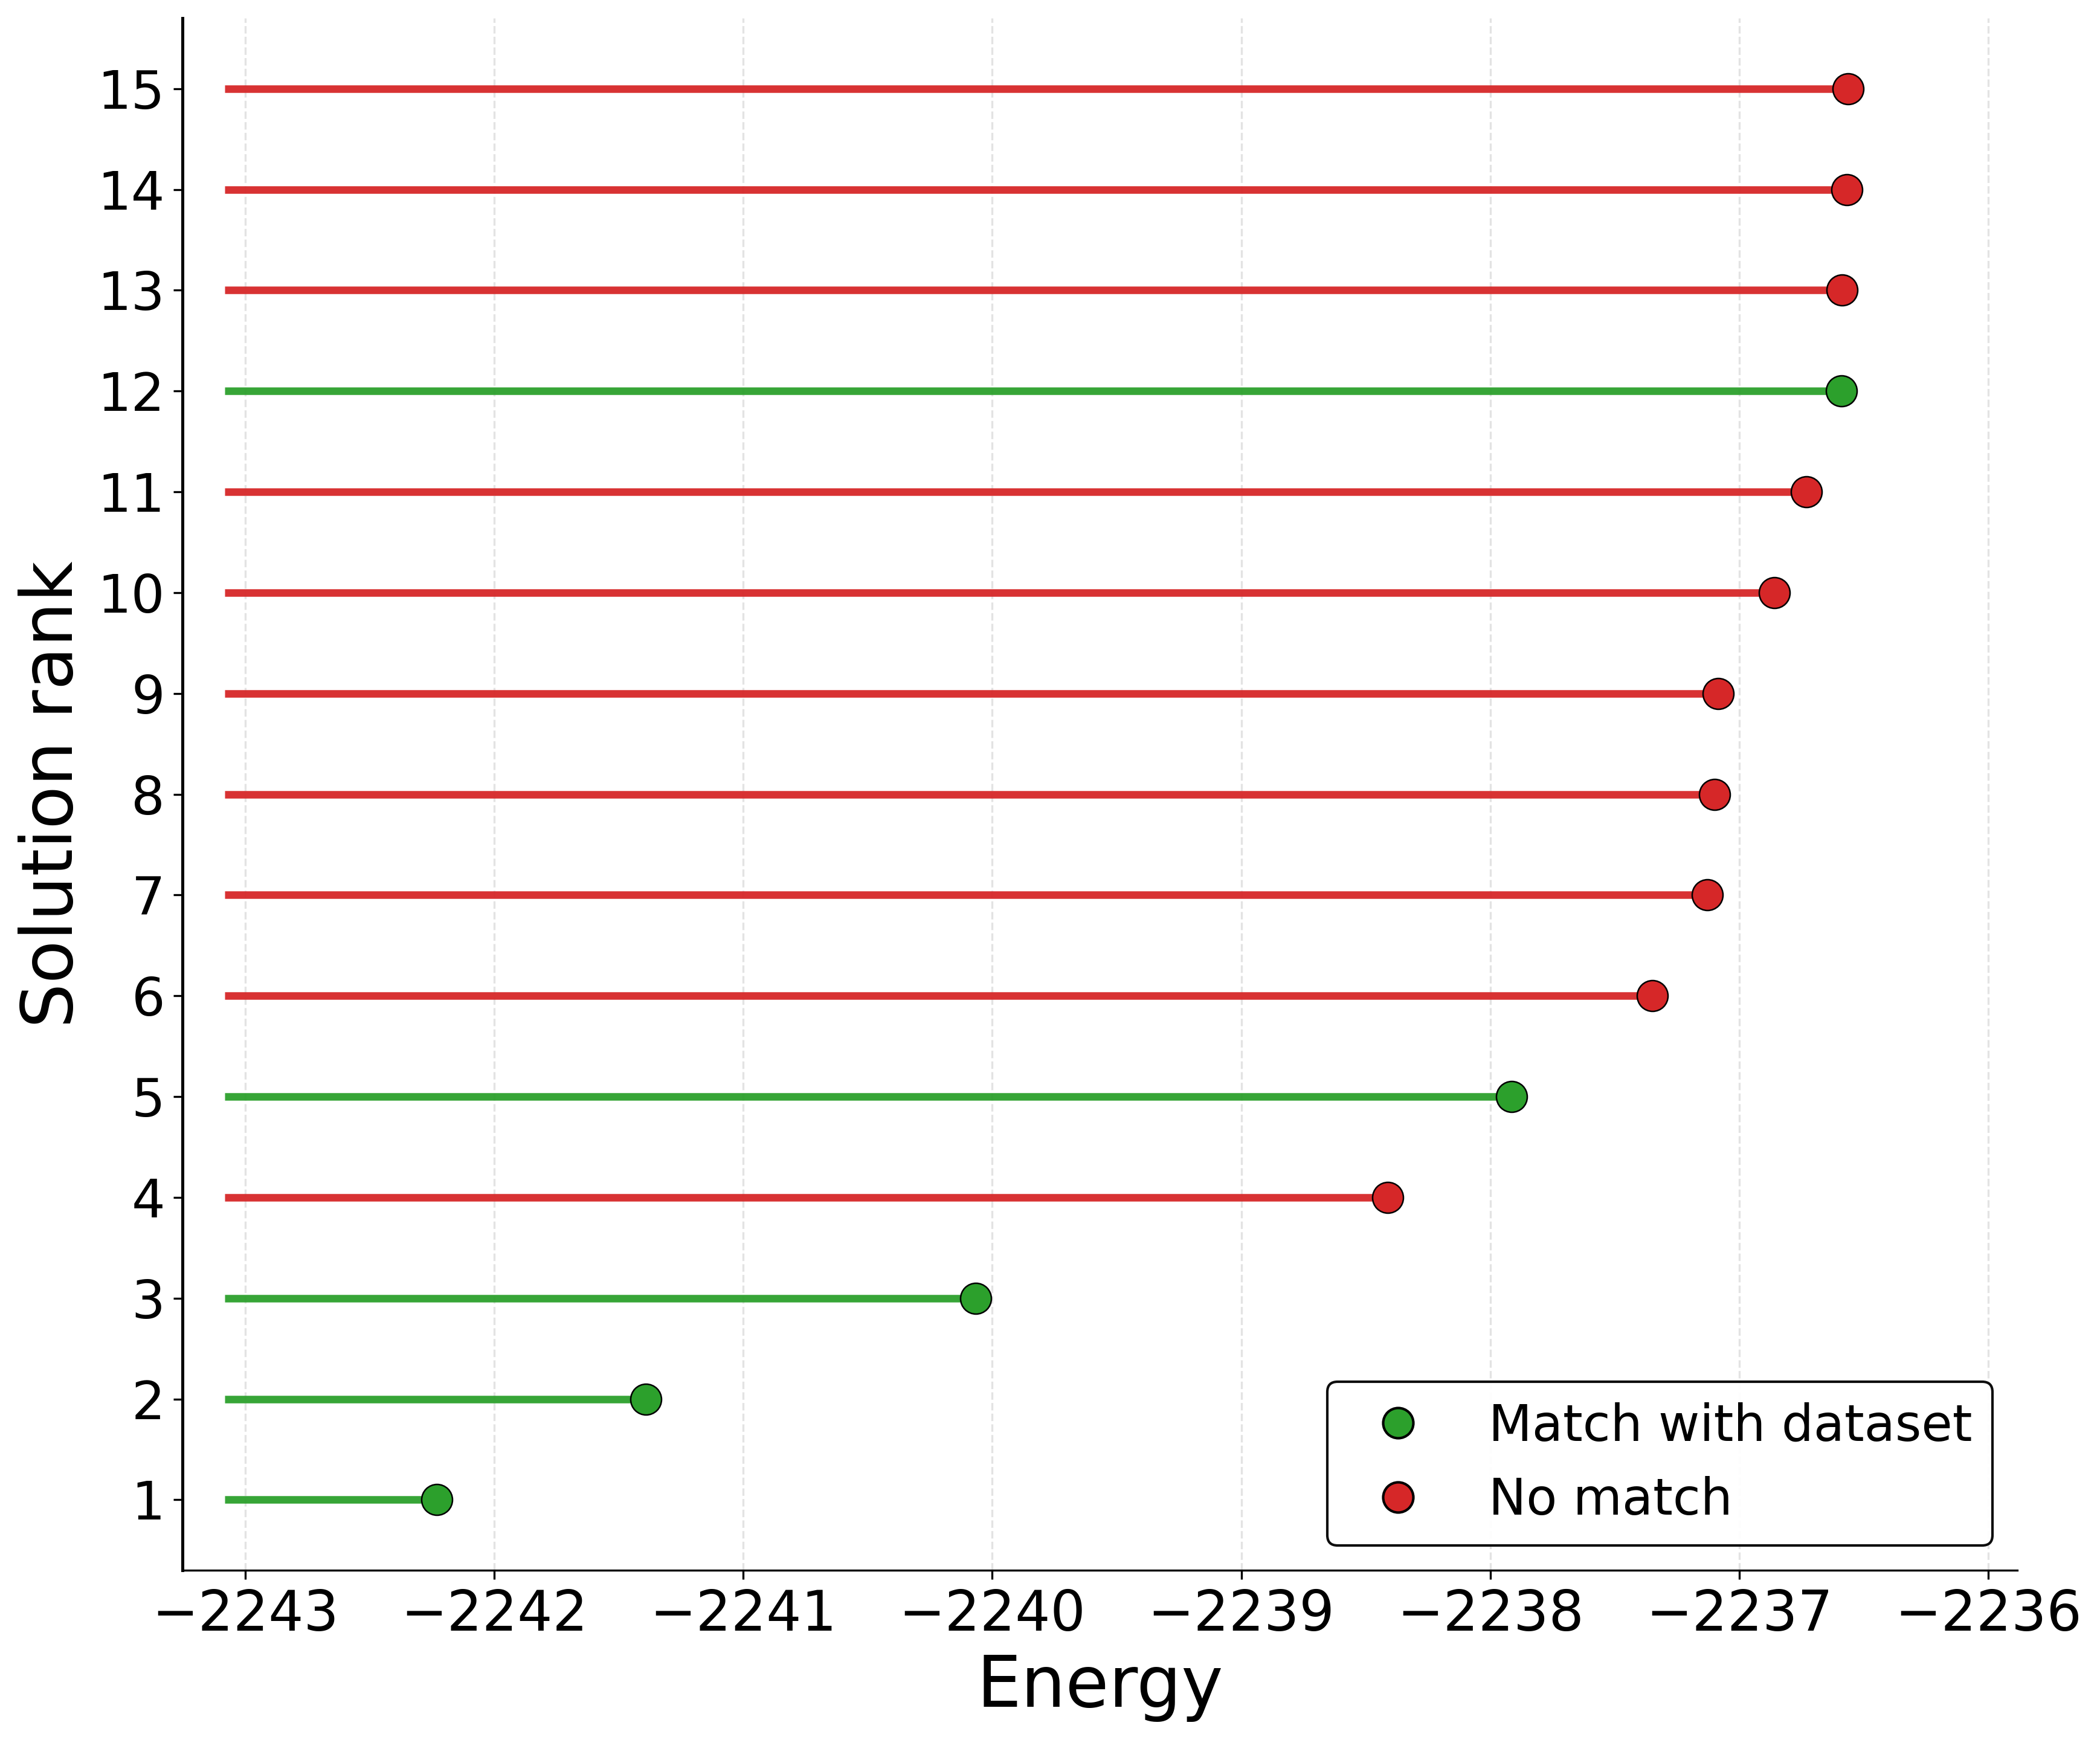

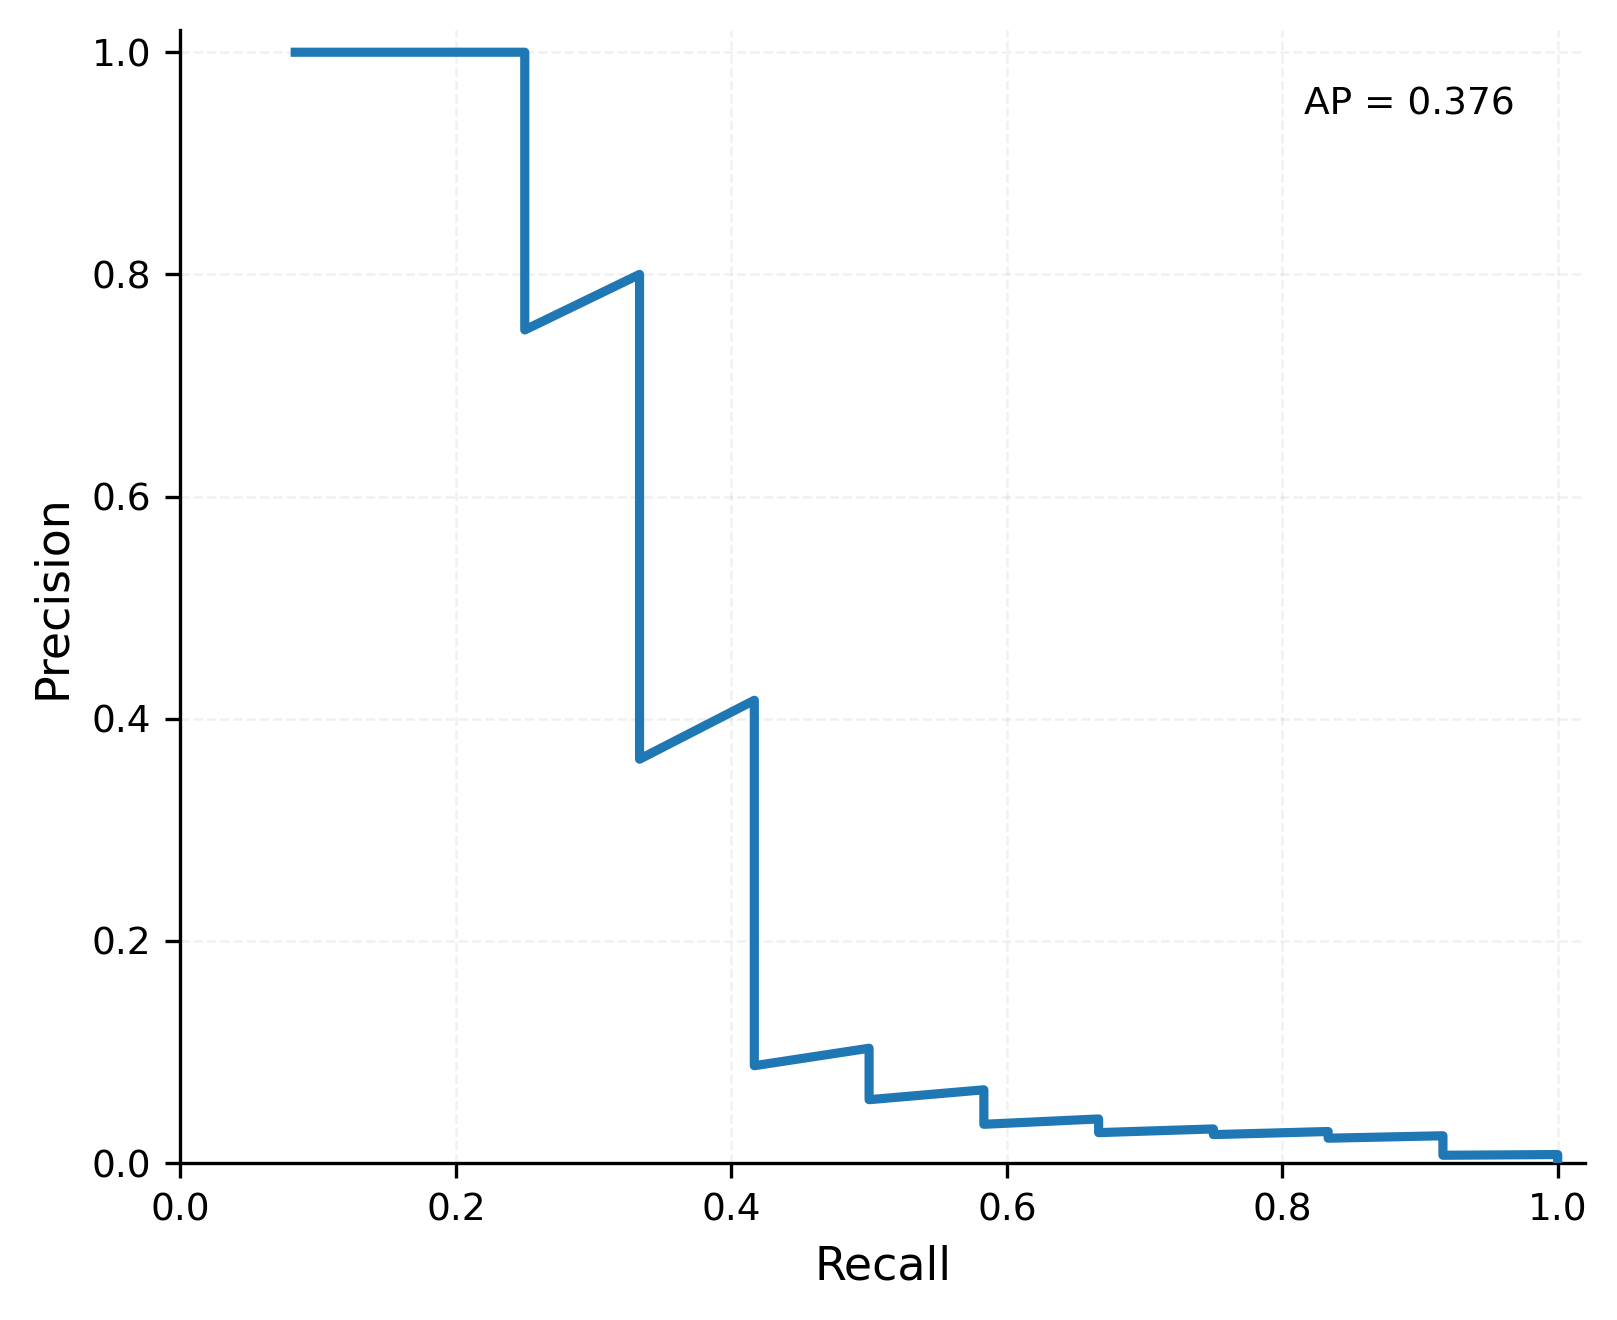

In [263]:
from qubo_selection import get_sorted_results_allowed_sizes
from parameter_optimization import plot_energy_spectrum, get_ground_truth_combinations, plot_and_compute_precision_recall_curve

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])

spectrum_50_fig = plot_energy_spectrum(sorted_results, top_n=15, disease_name=disease)

sp50_fig_path = os.path.join("Images", f"energy_spectrum_50_{disease}.pdf")

spectrum_50_fig.savefig(sp50_fig_path, format='pdf', bbox_inches="tight")

ap, precision, recall, pr_50_fig = plot_and_compute_precision_recall_curve(
    sorted_results=sorted_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_50_fig_path = os.path.join("Images", f"pr_curve_50_{disease}.pdf")
pr_50_fig.savefig(pr_50_fig_path, format="pdf", bbox_inches="tight")

In [282]:
disease = 'Brain Neoplasms'

disease_str = disease.replace(" ", "_")

ap_qubo_file_50 = os.path.join("Results", f"best_ap_qubo_{disease}_50.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_qubo, ap_qubo_file_50, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_qubo_50 = load_qubo_from_file(ap_qubo_file_50)

In [301]:
from simulated_quantum_annealing import parameter_exploration

enlarged_qubo = best_qubo_50
enlarged_drug_set = ['DB00361', 'DB00014', 'DB00445', 'DB00603', 'DB00675', 'DB00783', 'DB01006', 'DB01101', 'DB01248', 'DB01135', 'DB08653', 'DB01339', 'DB07886', 'DB06196', 'DB00246', 'DB01003', 'DB00731', 'DB00382', 'DB01285', 'DB02459', 'DB00321', 'DB02721', 'DB00878', 'DB03535', 'DB00477', 'DB01200', 'DB01528', 'DB08612', 'DB02763', 'DB01628', 'DB00182', 'DB00381', 'DB04842', 'DB07790', 'DB00363', 'DB00589', 'DB00598', 'DB04794', 'DB01267', 'DB00393', 'DB00420', 'DB00762', 'DB01159', 'DB01287', 'DB01288', 'DB06834', 'DB01064', 'DB08429', 'DB00370', 'DB01351']
gt_combinations = get_ground_truth_combinations(disease, combinations_df)

parameter_exploration(enlarged_qubo, enlarged_drug_set, gt_combinations, outdir="sqa_runs_BN", top_k=10, num_reads_default=1024, repeats_per_setting=1)


Running 2 unique parameter settings, each repeated 1 times -> total runs = 2
[1] params: linear repeat 1/1 seed=1000
Sampler failed for params: {'beta_range': (0.01, 1.9), 'beta_schedule_type': 'linear', 'num_sweeps': 1, 'num_sweeps_per_beta': 2, 'Gamma': 1.0, 'num_reads': 1024} error: 'num_sweeps' must be a positive value divisible by 'num_sweeps_per_beta'.
[2] params: custom repeat 1/1 seed=1000
run=2 type=custom alpha=3.0 n_steps=20001 beta_max=1.0 spb=2 reads=1024 nsweeps=None Gamma=1.0
Saved sqa_runs_BN\rankfreq_custom_n20001_alpha3.0_bmax1.0_reads1024_r1.pdf | top1_frac=0.0811 top5_frac=0.1836
All parameter runs complete. Check: sqa_runs_BN


## Disease #3 - Rheumatoid Arthritis

10
Selected drugs: ['DB00091', 'DB00328', 'DB00608', 'DB00563', 'DB00860', 'DB00586', 'DB00995', 'DB00741', 'DB01097', 'DB01611']
Best AP: 0.5940 at gamma=4.845272206303725, beta=13.616045845272206


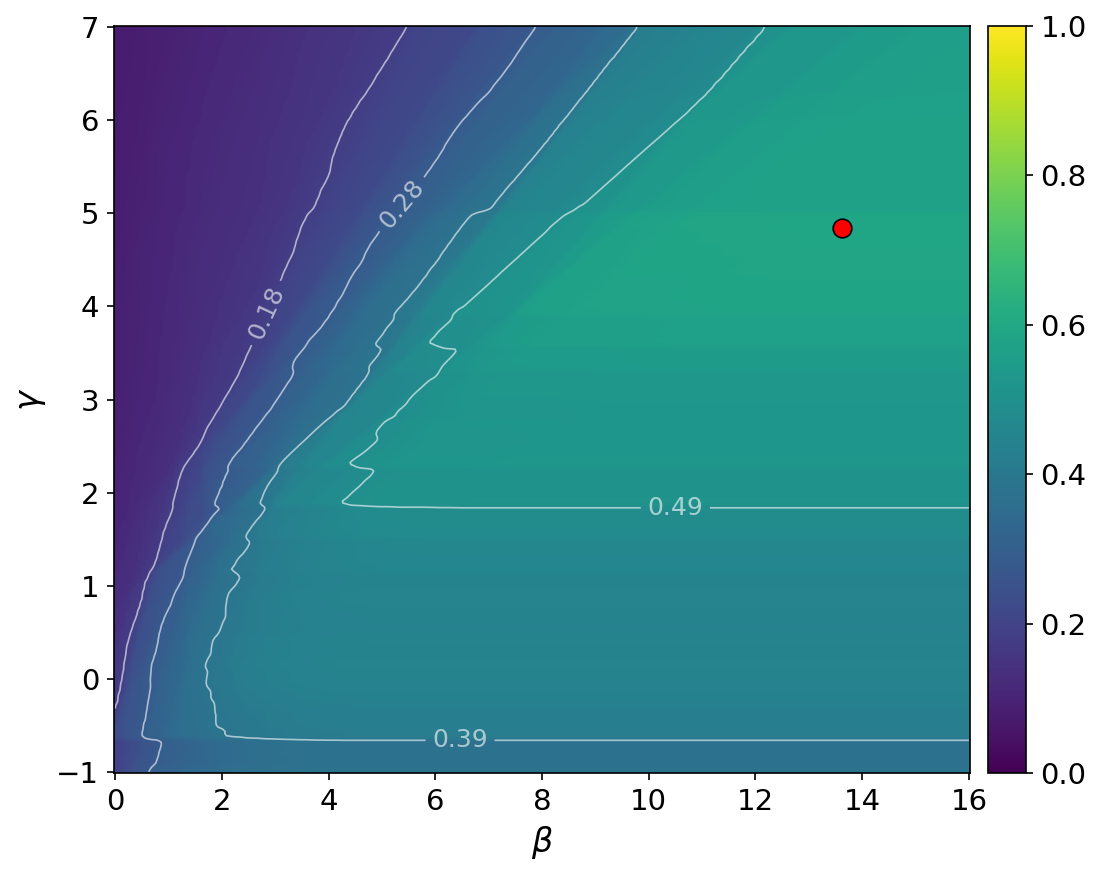

In [269]:
from parameter_optimization import optimize_for_ap, get_ground_truth_combinations, get_exact_low_energy_states, plot_metric_results
import numpy as np

disease = 'Rheumatoid Arthritis'
num_trials = 1 # for testing different random drug paddings if wanted 
z_score_samples = 15000  
gamma_grid = np.linspace(-1, 7, 350)
beta_grid = np.linspace(0, 16, 350)

initial_drug_ids = ['DB00091', 'DB00328', 'DB00608', 'DB00563', 'DB00860', 'DB00586', 'DB00995', 'DB00741', 'DB01097', 'DB01611'] # A subset of the unique drugs in the verified combinations for this disease

num_qubits =  len(initial_drug_ids) # Use all unique drugs in the verified combinations for this disease
    
print(num_qubits)
results = optimize_for_ap(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    num_qubits=num_qubits,
    gamma_values=gamma_grid,
    beta_values=beta_grid,
    initial_drug_ids=initial_drug_ids,
    num_trials=num_trials,
    num_samples=z_score_samples
)

(best_ap_drug_ids, best_ap_score, best_ap_qubo, best_ap_gamma, best_ap_beta,
 metric_matrices, fig, ax) = results

print(f"Best AP: {best_ap_score:.4f} at gamma={best_ap_gamma}, beta={best_ap_beta}")

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

fig_path = os.path.join("Images", f"ap_landscape_{disease}.pdf")
fig.savefig(fig_path, format='pdf', bbox_inches="tight")


In [ ]:
disease = 'Rheumatoid Arthritis'

disease_str = disease.replace(" ", "_")

ap_qubo_file = os.path.join("Results", f"best_ap_qubo_{disease_str}.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_ap_qubo, ap_qubo_file, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_ap_qubo = load_qubo_from_file(ap_qubo_file)

Total relevant ground truth combinations: 11


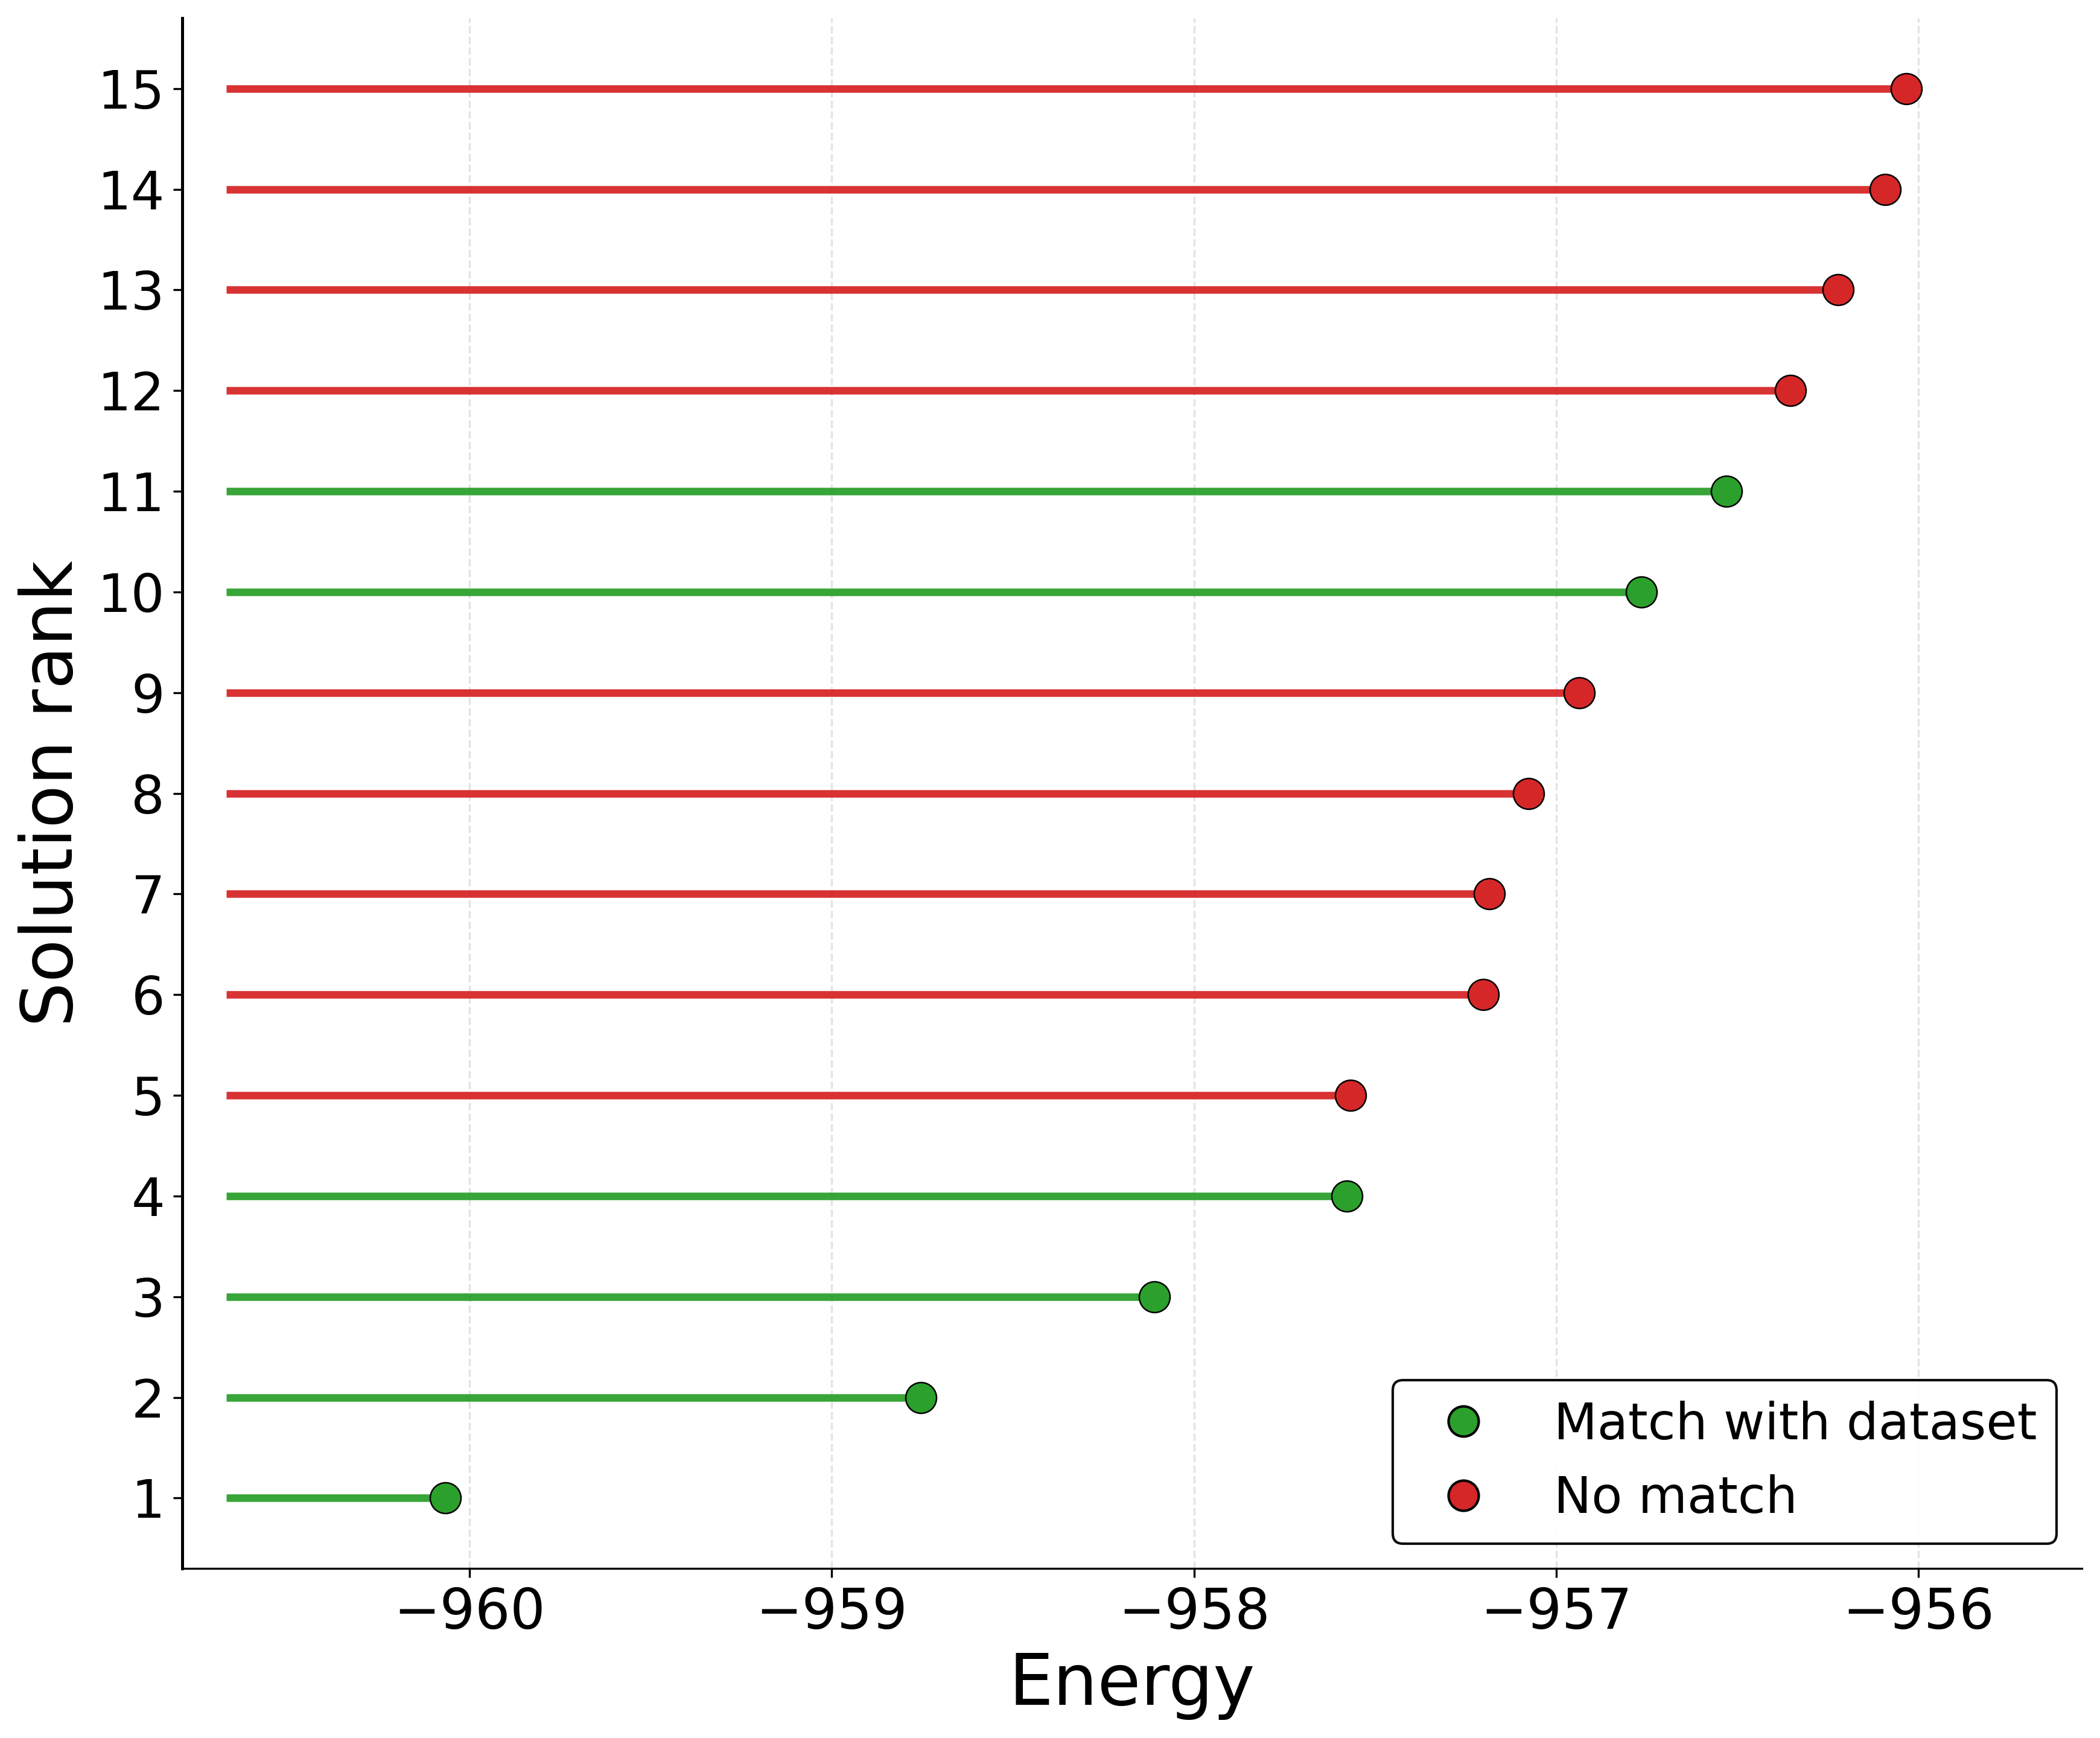

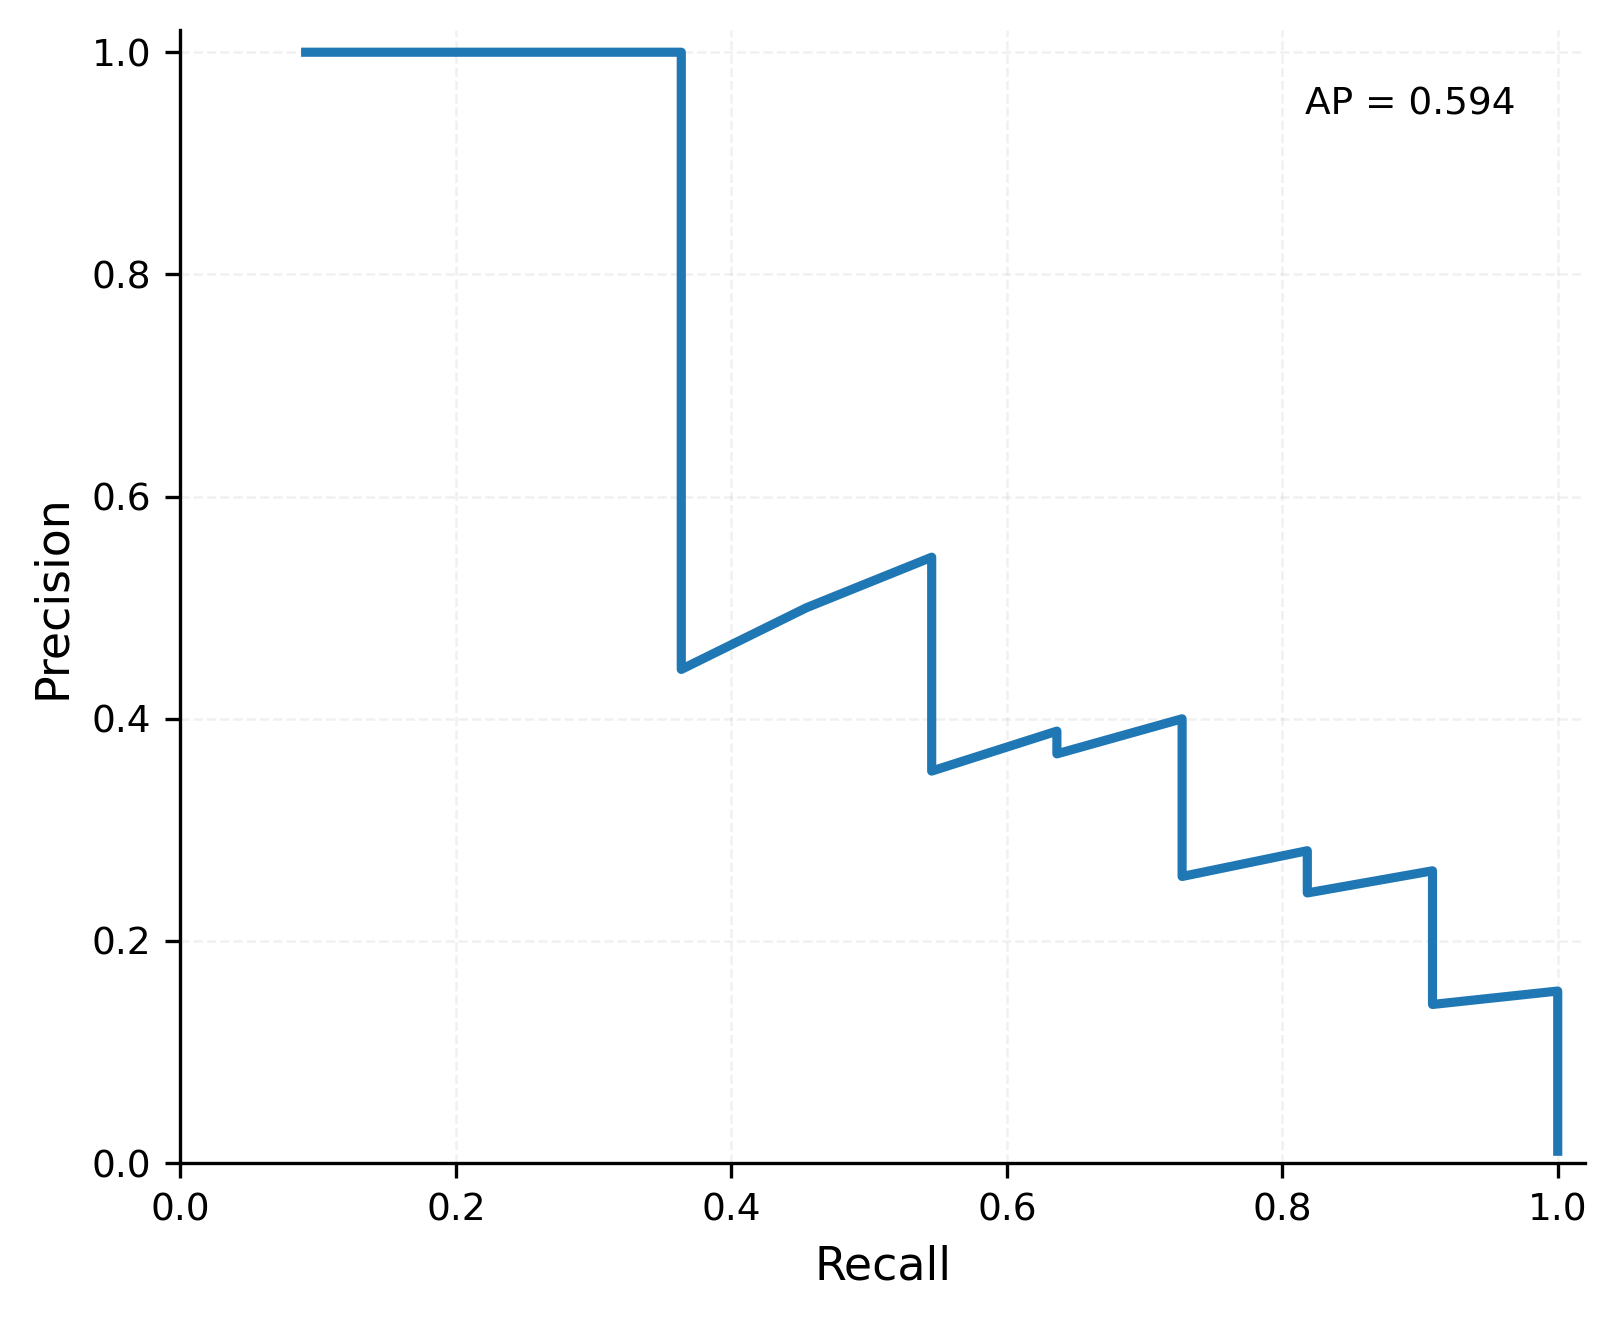

In [271]:
from parameter_optimization import plot_energy_spectrum, plot_and_compute_precision_recall_curve, get_exact_low_energy_states

exact_results = get_exact_low_energy_states(
    qubo=best_ap_qubo,
    drug_ids=best_ap_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      # Return up to this number of states
    energy_threshold=10000.0  # Only states within this energy of ground state
)

spectrum_fig = plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=15,
    disease_name=disease
)

sp_fig_path = os.path.join("Images", f"energy_spectrum_{disease}.pdf")
spectrum_fig.savefig(sp_fig_path, format="pdf", bbox_inches="tight")

ap, precision, recall, pr_fig = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_fig_path = os.path.join("Images", f"pr_curve_{disease}.pdf")
pr_fig.savefig(pr_fig_path, format="pdf", bbox_inches="tight")


In [310]:
from qubo_selection import find_best_qubo_for_params_ap_enumeration

disease = 'Rheumatoid Arthritis'

#Example set of 50 drugs (10 from verified combinations, 40 random)
initial_drug_ids = ['DB00091', 'DB00328', 'DB00608', 'DB00563', 'DB00860', 'DB00586', 'DB00995', 'DB00741', 'DB01097', 'DB01611', 'DB00696', 'DB07009', 'DB00297', 'DB08036', 'DB01958', 'DB00408', 'DB08025', 'DB08916', 'DB01275', 'DB07244', 'DB00731', 'DB02309', 'DB03059', 'DB03643', 'DB00524', 'DB00051', 'DB00266', 'DB00280', 'DB04077', 'DB04946', 'DB00358', 'DB00170', 'DB07638', 'DB00514', 'DB01420', 'DB02482', 'DB06716', 'DB01142', 'DB04829', 'DB00656', 'DB00321', 'DB04630', 'DB00706', 'DB03796', 'DB00568', 'DB03721', 'DB00786', 'DB04066', 'DB00714', 'DB01041']


allowed_sizes=[2,3]
return_curve= False
best_ap_gamma = 5.1759
best_ap_beta = 14.472
num_trials = 1
z_score_samples = 20000
num_qubits = 50
print(len(initial_drug_ids))

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=initial_drug_ids,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

print("Best AP:", best_ap)
print("Best Drugs:")
print(best_drugs) 

50
Enumerated 20825 candidates; positives=11; AP=0.398685
 #1: energy=-1132.48, pos=1, sel=('DB00563', 'DB01611')
 #2: energy=-1130.96, pos=1, sel=('DB00563', 'DB00860')
 #3: energy=-1130.42, pos=1, sel=('DB00860', 'DB01611')
 #4: energy=-1130.09, pos=0, sel=('DB00563', 'DB01041')
 #5: energy=-1129.75, pos=1, sel=('DB00563', 'DB01097')
 #6: energy=-1129.73, pos=0, sel=('DB00563', 'DB00741')
 #7: energy=-1129.63, pos=0, sel=('DB00563', 'DB00051')
 #8: energy=-1129.54, pos=0, sel=('DB00563', 'DB02482')
 #9: energy=-1129.38, pos=0, sel=('DB00328', 'DB00563')
 #10: energy=-1129.37, pos=0, sel=('DB00608', 'DB00563')
[Trial 0] ap=0.398685
Best AP: 0.39868505811979343
Best Drugs:
['DB00091', 'DB00328', 'DB00608', 'DB00563', 'DB00860', 'DB00586', 'DB00995', 'DB00741', 'DB01097', 'DB01611', 'DB00696', 'DB07009', 'DB00297', 'DB08036', 'DB01958', 'DB00408', 'DB08025', 'DB08916', 'DB01275', 'DB07244', 'DB00731', 'DB02309', 'DB03059', 'DB03643', 'DB00524', 'DB00051', 'DB00266', 'DB00280', 'DB04077'

Total relevant ground truth combinations: 11


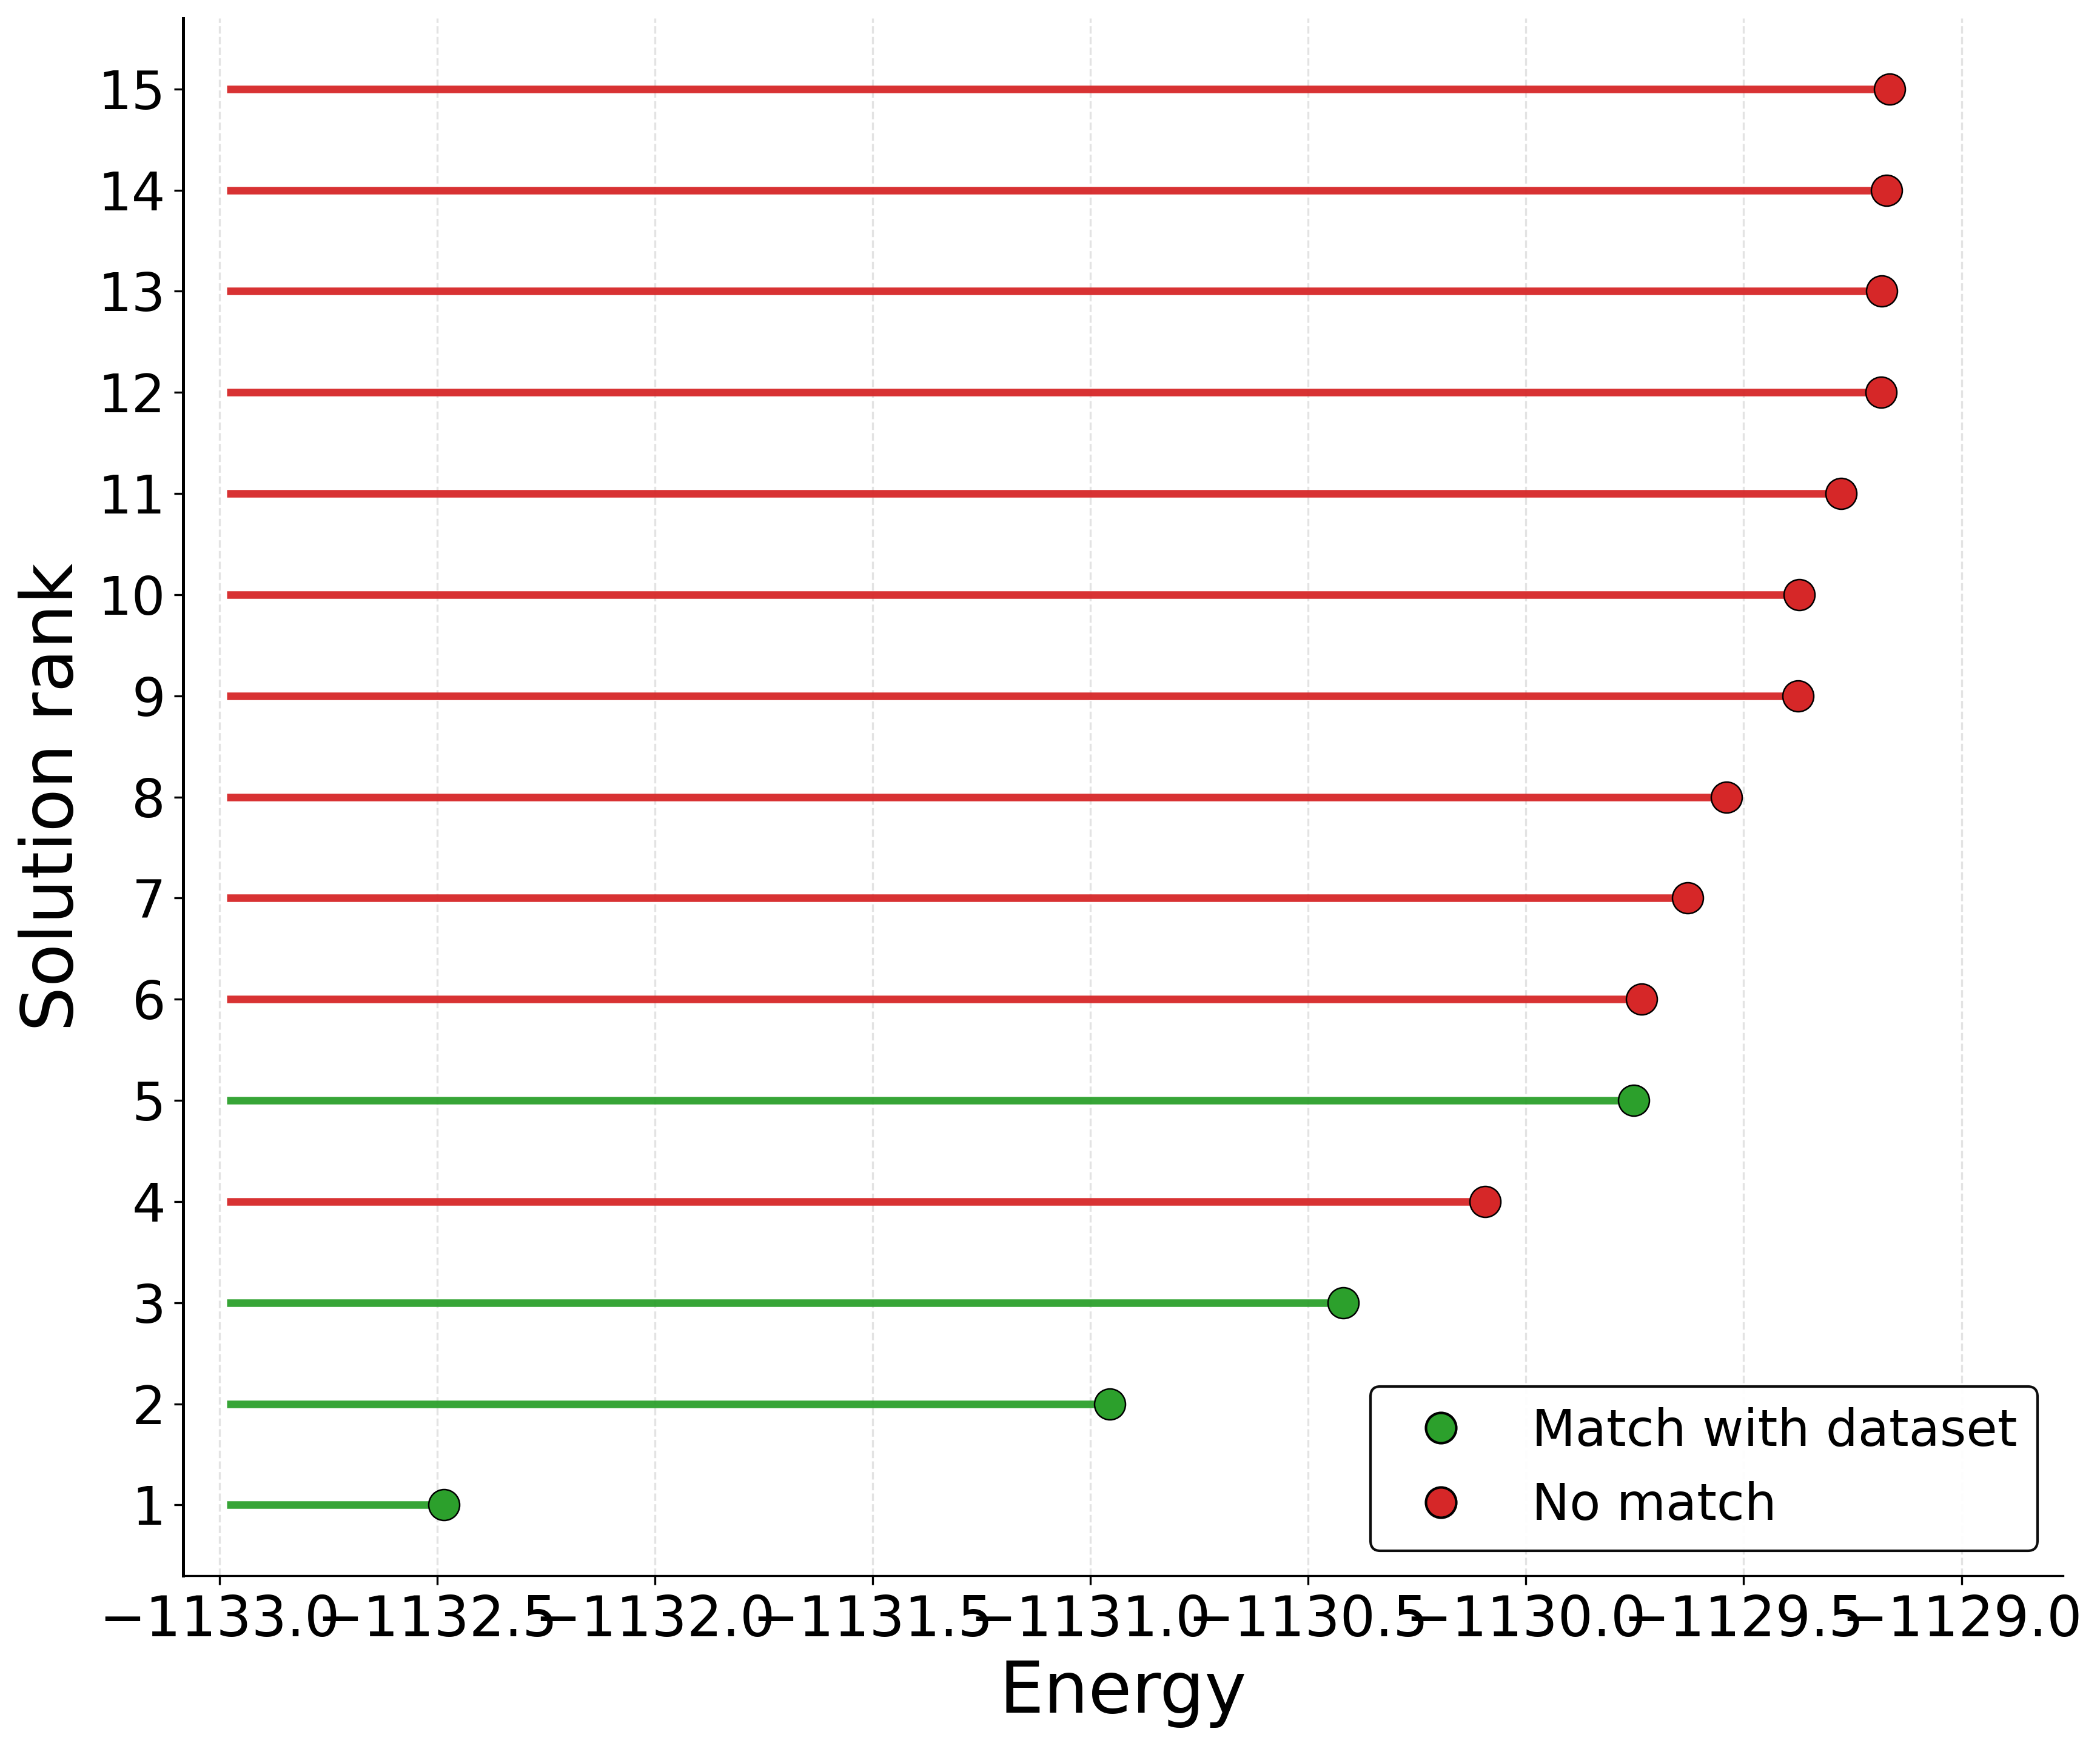

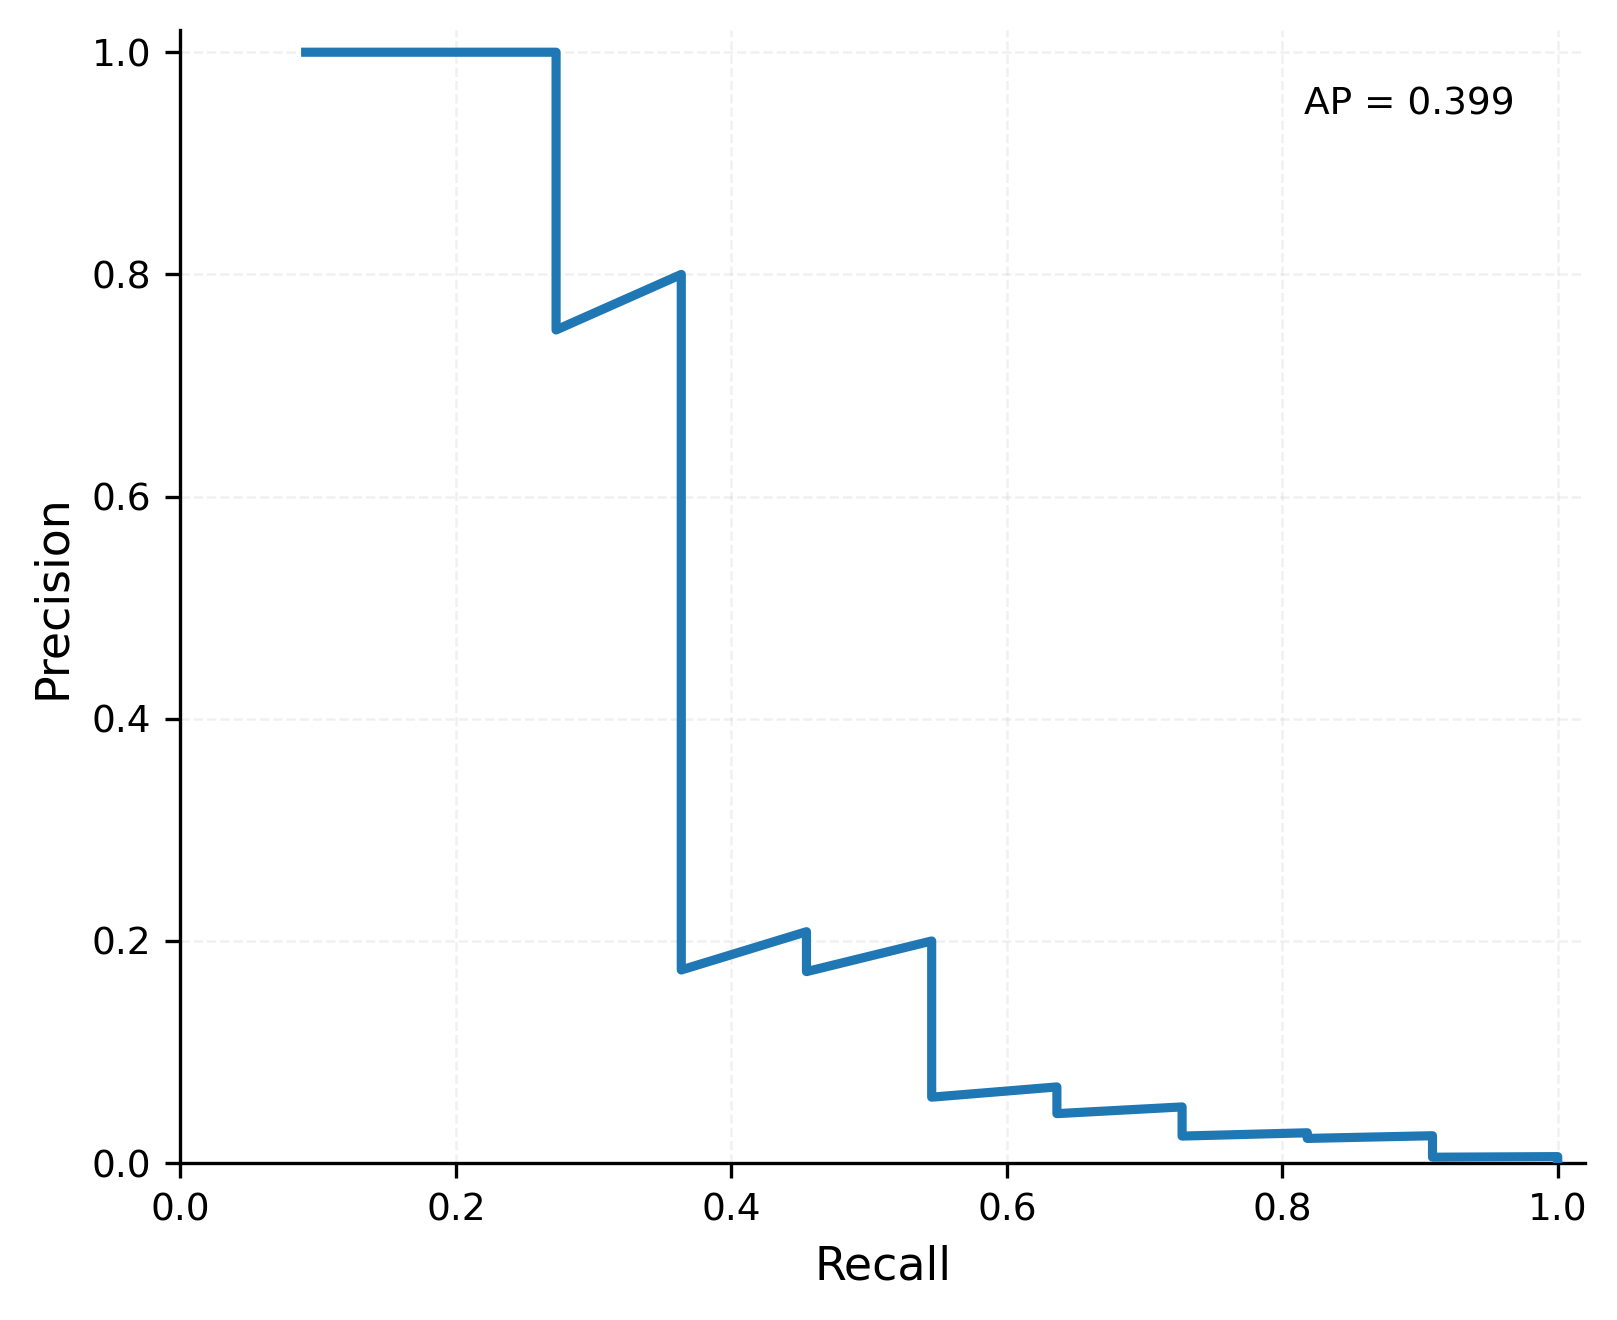

In [311]:
from qubo_selection import get_sorted_results_allowed_sizes
from parameter_optimization import plot_energy_spectrum, get_ground_truth_combinations, plot_and_compute_precision_recall_curve

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])

spectrum_50_fig = plot_energy_spectrum(sorted_results, top_n=15, disease_name=disease)

sp50_fig_path = os.path.join("Images", f"energy_spectrum_50_{disease}.pdf")

spectrum_50_fig.savefig(sp50_fig_path, format='pdf', bbox_inches="tight")

ap, precision, recall, pr_50_fig = plot_and_compute_precision_recall_curve(
    sorted_results=sorted_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_50_fig_path = os.path.join("Images", f"pr_curve_50_{disease}.pdf")
pr_50_fig.savefig(pr_50_fig_path, format="pdf", bbox_inches="tight")


In [ ]:
disease_str = disease.replace(" ", "_")

ap_qubo_file_50 = os.path.join("Results", f"best_ap_qubo_{disease}_50.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_qubo, ap_qubo_file_50, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_qubo_50 = load_qubo_from_file(ap_qubo_file_50)

In [315]:
from simulated_quantum_annealing import parameter_exploration

disease = 'Rheumatoid Arthritis'
enlarged_qubo = best_qubo_50
enlarged_drug_set =['DB00091', 'DB00328', 'DB00608', 'DB00563', 'DB00860', 'DB00586', 'DB00995', 'DB00741', 'DB01097', 'DB01611', 'DB00696', 'DB07009', 'DB00297', 'DB08036', 'DB01958', 'DB00408', 'DB08025', 'DB08916', 'DB01275', 'DB07244', 'DB00731', 'DB02309', 'DB03059', 'DB03643', 'DB00524', 'DB00051', 'DB00266', 'DB00280', 'DB04077', 'DB04946', 'DB00358', 'DB00170', 'DB07638', 'DB00514', 'DB01420', 'DB02482', 'DB06716', 'DB01142', 'DB04829', 'DB00656', 'DB00321', 'DB04630', 'DB00706', 'DB03796', 'DB00568', 'DB03721', 'DB00786', 'DB04066', 'DB00714', 'DB01041']

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

parameter_exploration(enlarged_qubo, enlarged_drug_set, gt_combinations, outdir="sqa_runs_RA", top_k=10, num_reads_default=1024, repeats_per_setting=1)


Running 2 unique parameter settings, each repeated 1 times -> total runs = 2
[1] params: linear repeat 1/1 seed=1000
Sampler failed for params: {'beta_range': (0.01, 1.9), 'beta_schedule_type': 'linear', 'num_sweeps': 1, 'num_sweeps_per_beta': 2, 'Gamma': 1.0, 'num_reads': 1024} error: 'num_sweeps' must be a positive value divisible by 'num_sweeps_per_beta'.
[2] params: custom repeat 1/1 seed=1000
run=2 type=custom alpha=0.5 n_steps=20001 beta_max=1.0 spb=2 reads=1024 nsweeps=None Gamma=1.0
Saved sqa_runs_RA\rankfreq_custom_n20001_alpha0.5_bmax1.0_reads1024_r1.pdf | top1_frac=0.2295 top5_frac=0.3486
All parameter runs complete. Check: sqa_runs_RA


## Disease #4 - Asthma

9
Selected drugs: ['DB00471', 'DB00549', 'DB00588', 'DB00635', 'DB00741', 'DB00860', 'DB01234', 'DB01274', 'DB01409']
Best AP: 0.6000 at gamma=1.458646616541353, beta=3.791979949874687


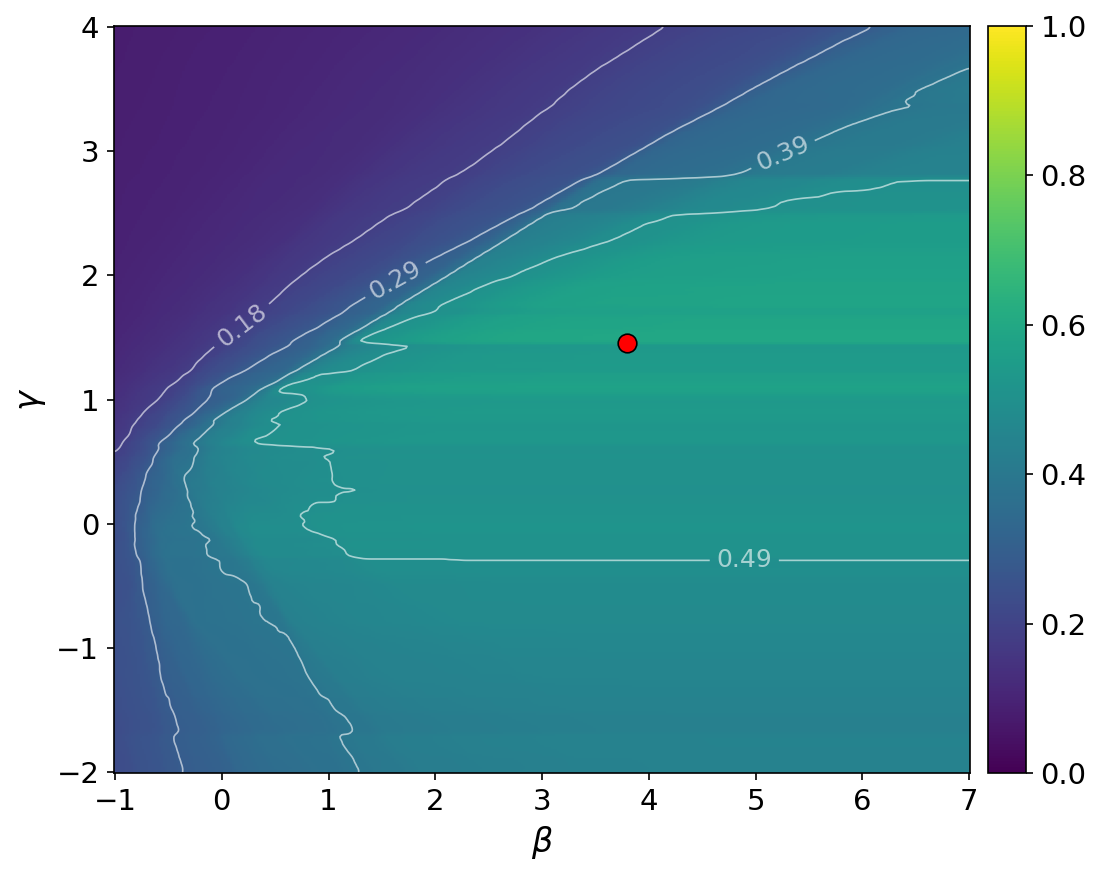

In [197]:
from parameter_optimization import optimize_for_ap, get_ground_truth_combinations, get_exact_low_energy_states, plot_metric_results
import numpy as np

disease = 'Asthma'
num_trials = 1 # for testing different random drug paddings if wanted 
z_score_samples = 15000  
gamma_grid = np.linspace(-2, 4, 400)
beta_grid = np.linspace(-1, 7, 400)

initial_drug_ids = ['DB00471','DB00549','DB00588','DB00635','DB00741','DB00860','DB01234','DB01274','DB01409'] # A subset of the unique drugs in the verified combinations for this disease

num_qubits =  len(initial_drug_ids) # Use all unique drugs in the verified combinations for this disease
    
print(num_qubits)
results = optimize_for_ap(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    num_qubits=num_qubits,
    gamma_values=gamma_grid,
    beta_values=beta_grid,
    initial_drug_ids=initial_drug_ids,
    num_trials=num_trials,
    num_samples=z_score_samples
)

(best_ap_drug_ids, best_ap_score, best_ap_qubo, best_ap_gamma, best_ap_beta,
 metric_matrices, fig, ax) = results

print(f"Best AP: {best_ap_score:.4f} at gamma={best_ap_gamma}, beta={best_ap_beta}")

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

fig_path = os.path.join("Images", f"ap_landscape_{disease}.pdf")
fig.savefig(fig_path, format='pdf', bbox_inches="tight")


In [276]:
disease = 'Asthma'

disease_str = disease.replace(" ", "_")

ap_qubo_file = os.path.join("Results", f"best_ap_qubo_{disease_str}.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_ap_qubo, ap_qubo_file, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_ap_qubo = load_qubo_from_file(ap_qubo_file)

Total relevant ground truth combinations: 11


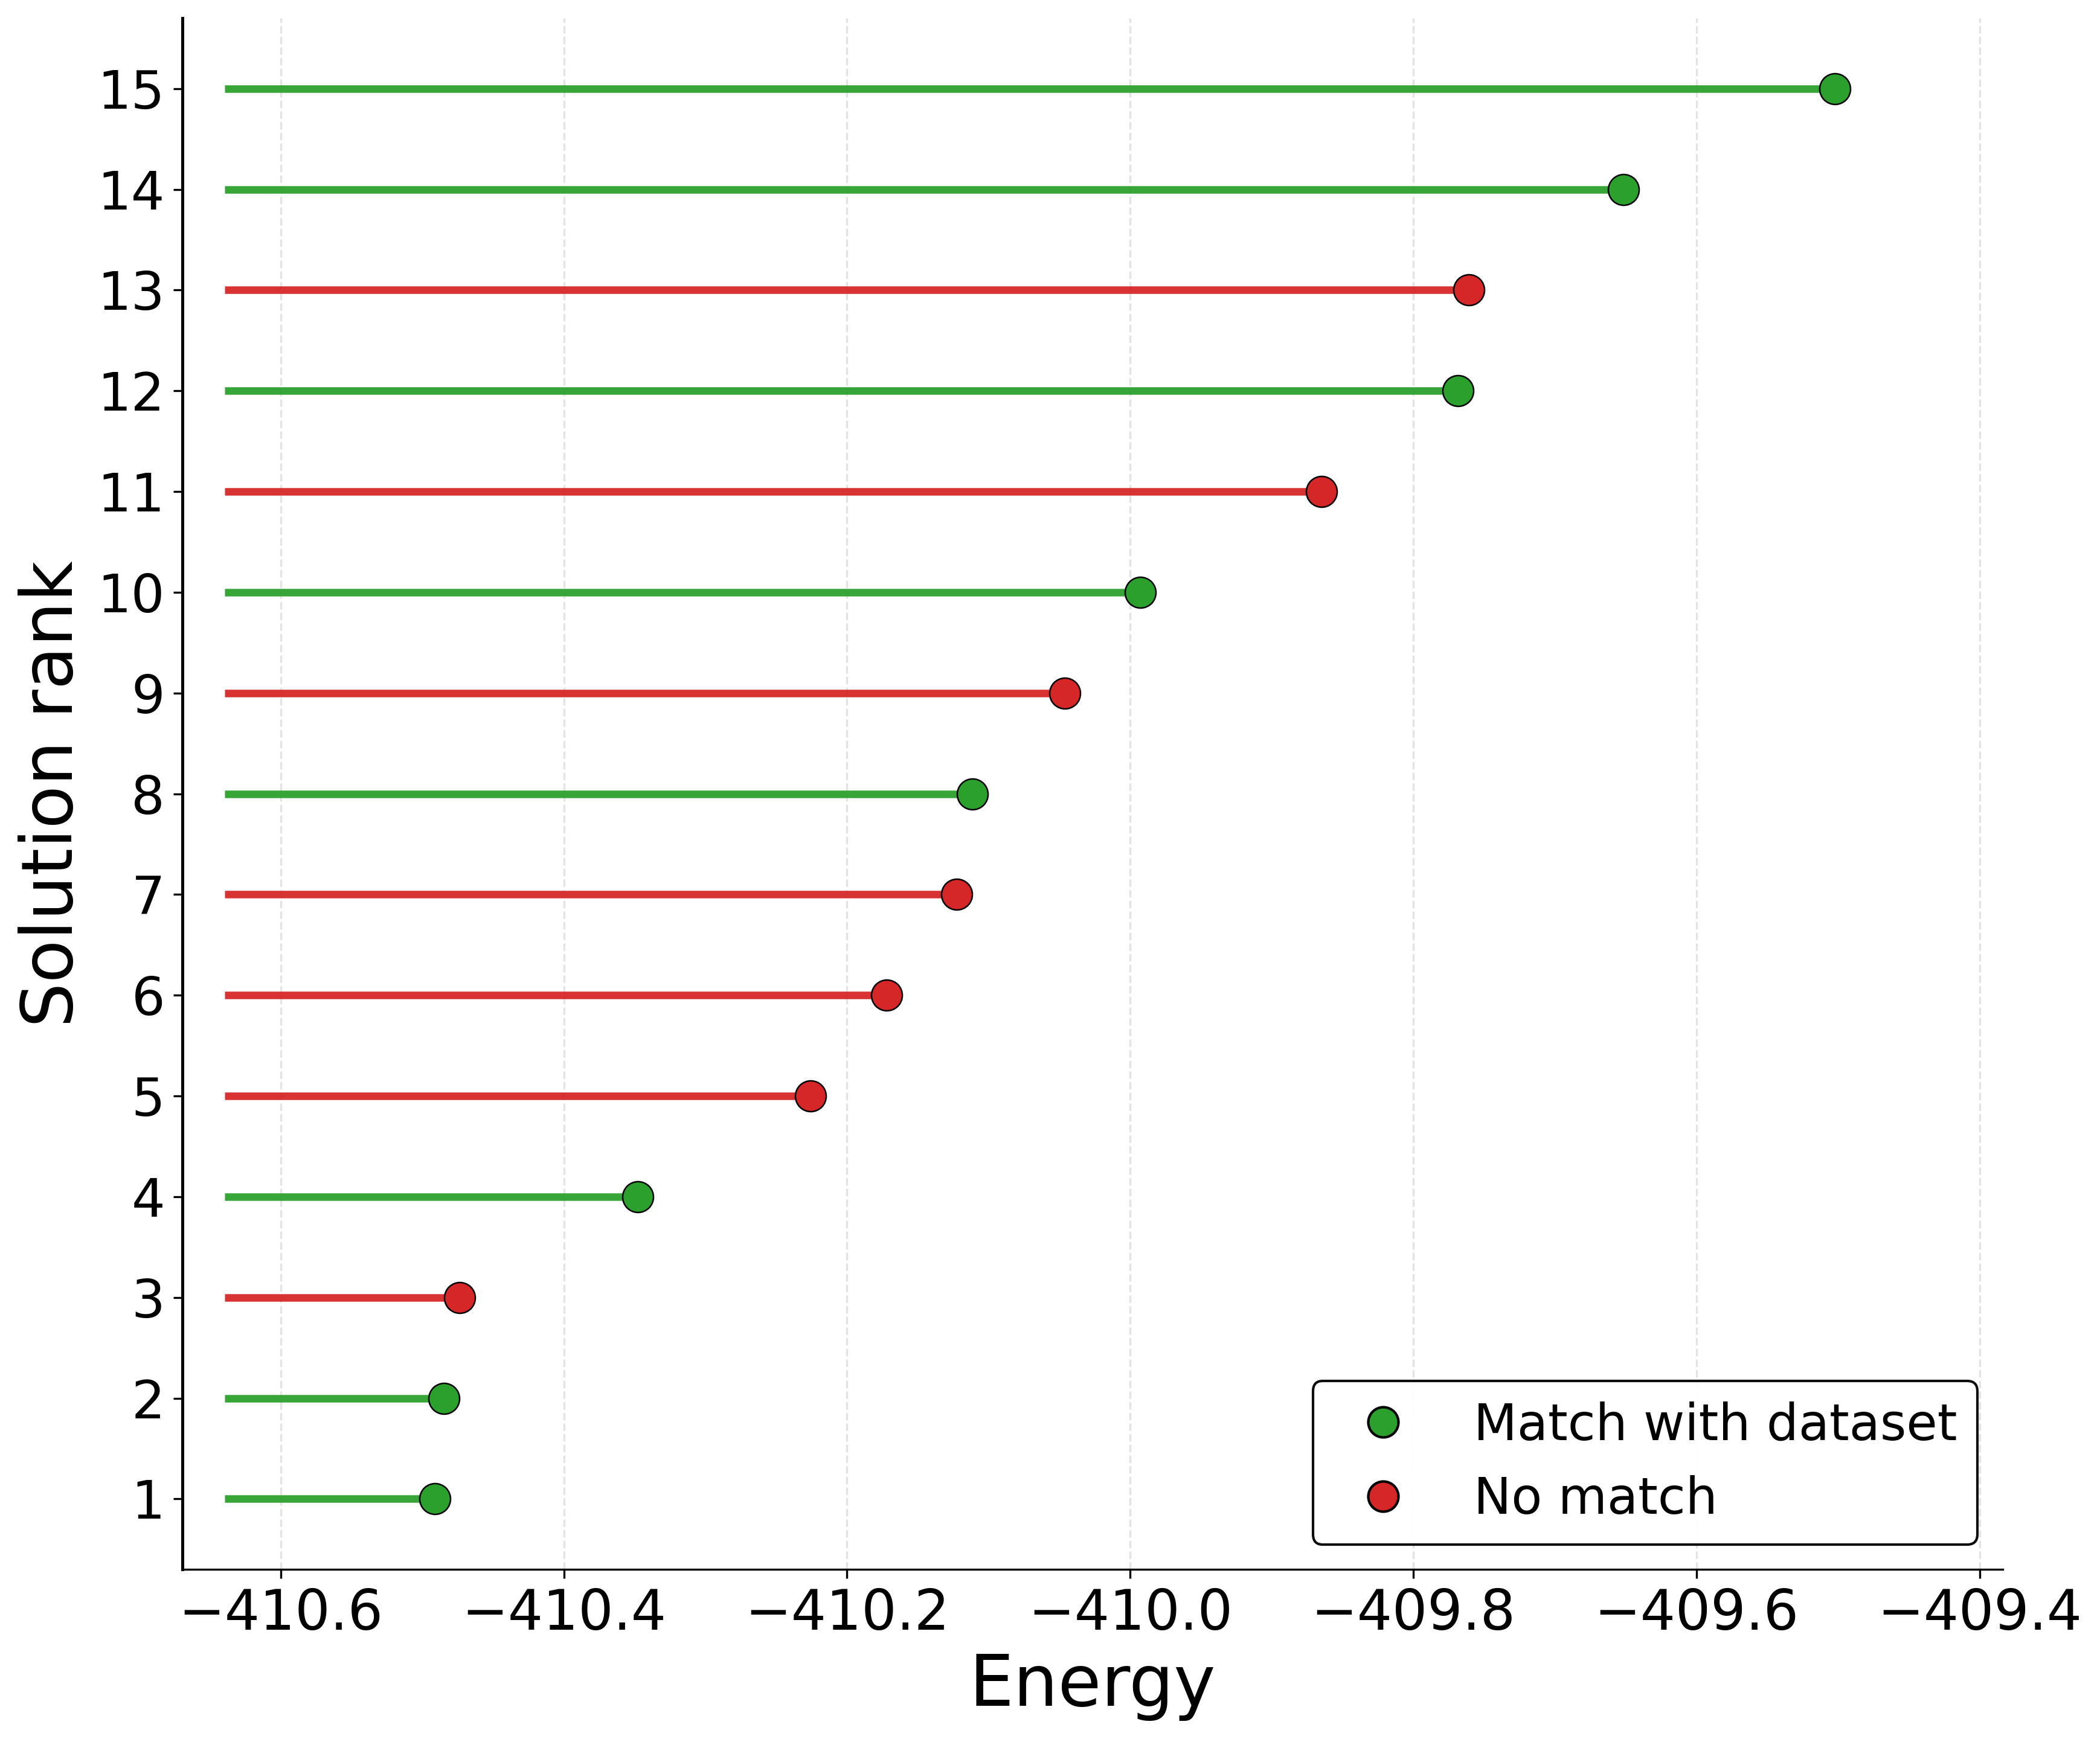

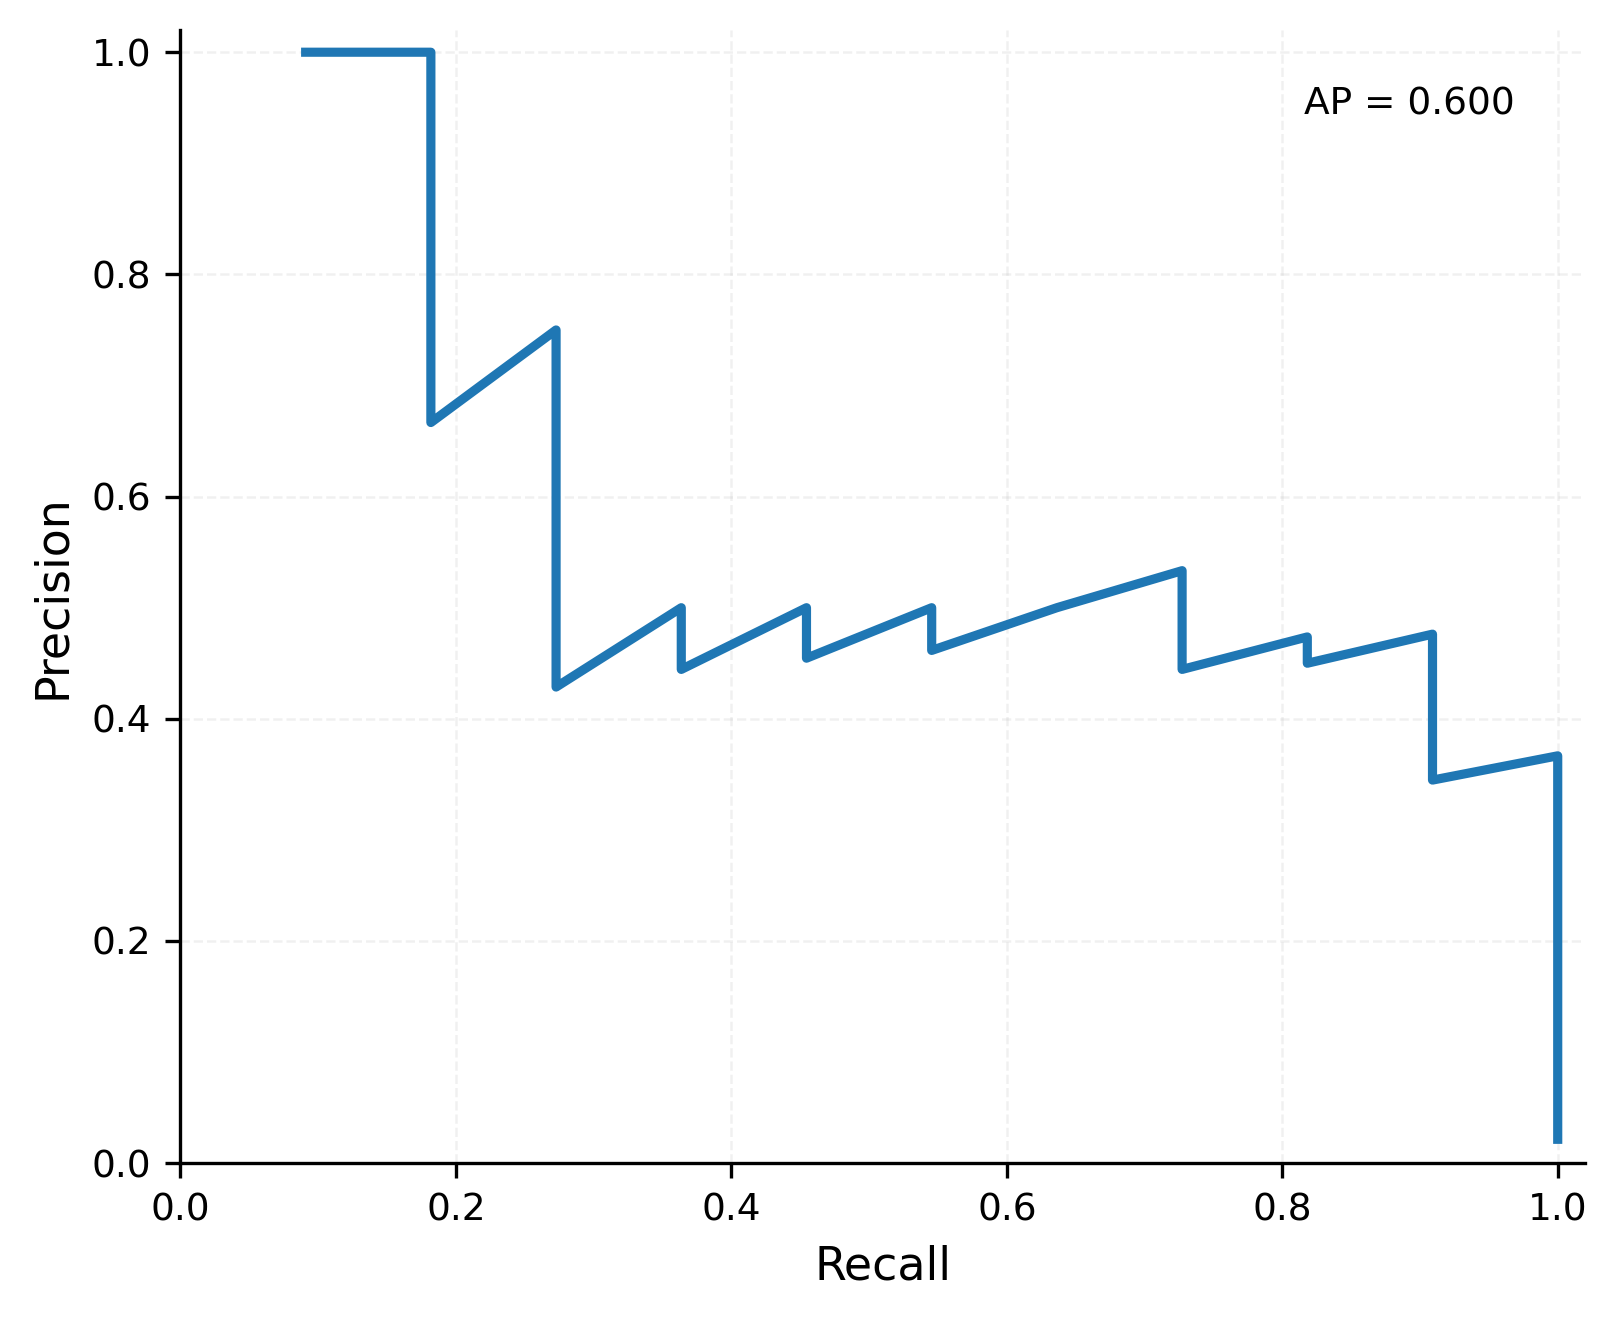

In [278]:
from parameter_optimization import plot_energy_spectrum, plot_and_compute_precision_recall_curve, get_exact_low_energy_states

best_ap_drug_ids = ['DB00471','DB00549','DB00588','DB00635','DB00741','DB00860','DB01234','DB01274','DB01409']
gt_combinations = get_ground_truth_combinations(disease, combinations_df)

exact_results = get_exact_low_energy_states(
    qubo=best_ap_qubo,
    drug_ids=best_ap_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      # Return up to this number of states
    energy_threshold=10000.0  # Only states within this energy of ground state
)

spectrum_fig = plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=15,
    disease_name=disease
)

sp_fig_path = os.path.join("Images", f"energy_spectrum_{disease}.pdf")
spectrum_fig.savefig(sp_fig_path, format="pdf", bbox_inches="tight")

ap, precision, recall, pr_fig = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_fig_path = os.path.join("Images", f"pr_curve_{disease}.pdf")
pr_fig.savefig(pr_fig_path, format="pdf", bbox_inches="tight")


In [ ]:
from qubo_selection import find_best_qubo_for_params_ap_enumeration

disease = 'Asthma'

#Example set of 50 drugs (9 from verified combinations, 41 random)
initial_drug_ids = ['DB00471', 'DB00549', 'DB00588', 'DB00635', 'DB00741', 'DB00860', 'DB01234', 'DB01274', 'DB01409', 'DB00917', 'DB08393', 'DB07835', 'DB02952', 'DB00774', 'DB01242', 'DB00334', 'DB01336', 'DB00108', 'DB00805', 'DB00002', 'DB00502', 'DB01235', 'DB01267', 'DB08877', 'DB00674', 'DB00934', 'DB04006', 'DB07070', 'DB07687', 'DB01252', 'DB04868', 'DB01115', 'DB00726', 'DB03865', 'DB00661', 'DB00960', 'DB08756', 'DB08465', 'DB01243', 'DB00050', 'DB00598', 'DB08124', 'DB07502', 'DB01199', 'DB06927', 'DB05414', 'DB07715', 'DB08162', 'DB00421', 'DB01064']


allowed_sizes=[2,3]
return_curve= False
best_ap_gamma = 1.459
best_ap_beta = 3.792
num_trials = 1
z_score_samples = 20000
num_qubits = 50
print(len(initial_drug_ids))

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=initial_drug_ids,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

print("Best AP:", best_ap)
print("Best Drugs:")
print(best_drugs) 

50
Enumerated 20825 candidates; positives=11; AP=0.405373
 #1: energy=-502.313, pos=1, sel=('DB00860', 'DB01409')
 #2: energy=-502.307, pos=1, sel=('DB00588', 'DB01409')
 #3: energy=-502.304, pos=0, sel=('DB00588', 'DB00860')
 #4: energy=-502.207, pos=0, sel=('DB00635', 'DB08465')
 #5: energy=-502.167, pos=1, sel=('DB00588', 'DB00635')
 #6: energy=-502.005, pos=0, sel=('DB00588', 'DB01274')
 #7: energy=-501.95, pos=0, sel=('DB00860', 'DB01274')
 #8: energy=-501.933, pos=0, sel=('DB00635', 'DB01409')
 #9: energy=-501.929, pos=1, sel=('DB00635', 'DB00860')
 #10: energy=-501.883, pos=0, sel=('DB00635', 'DB00050')
[Trial 0] ap=0.405373
Best AP: 0.40537346329262824
Best Drugs:
['DB00471', 'DB00549', 'DB00588', 'DB00635', 'DB00741', 'DB00860', 'DB01234', 'DB01274', 'DB01409', 'DB00917', 'DB08393', 'DB07835', 'DB02952', 'DB00774', 'DB01242', 'DB00334', 'DB01336', 'DB00108', 'DB00805', 'DB00002', 'DB00502', 'DB01235', 'DB01267', 'DB08877', 'DB00674', 'DB00934', 'DB04006', 'DB07070', 'DB07687',

Total relevant ground truth combinations: 11


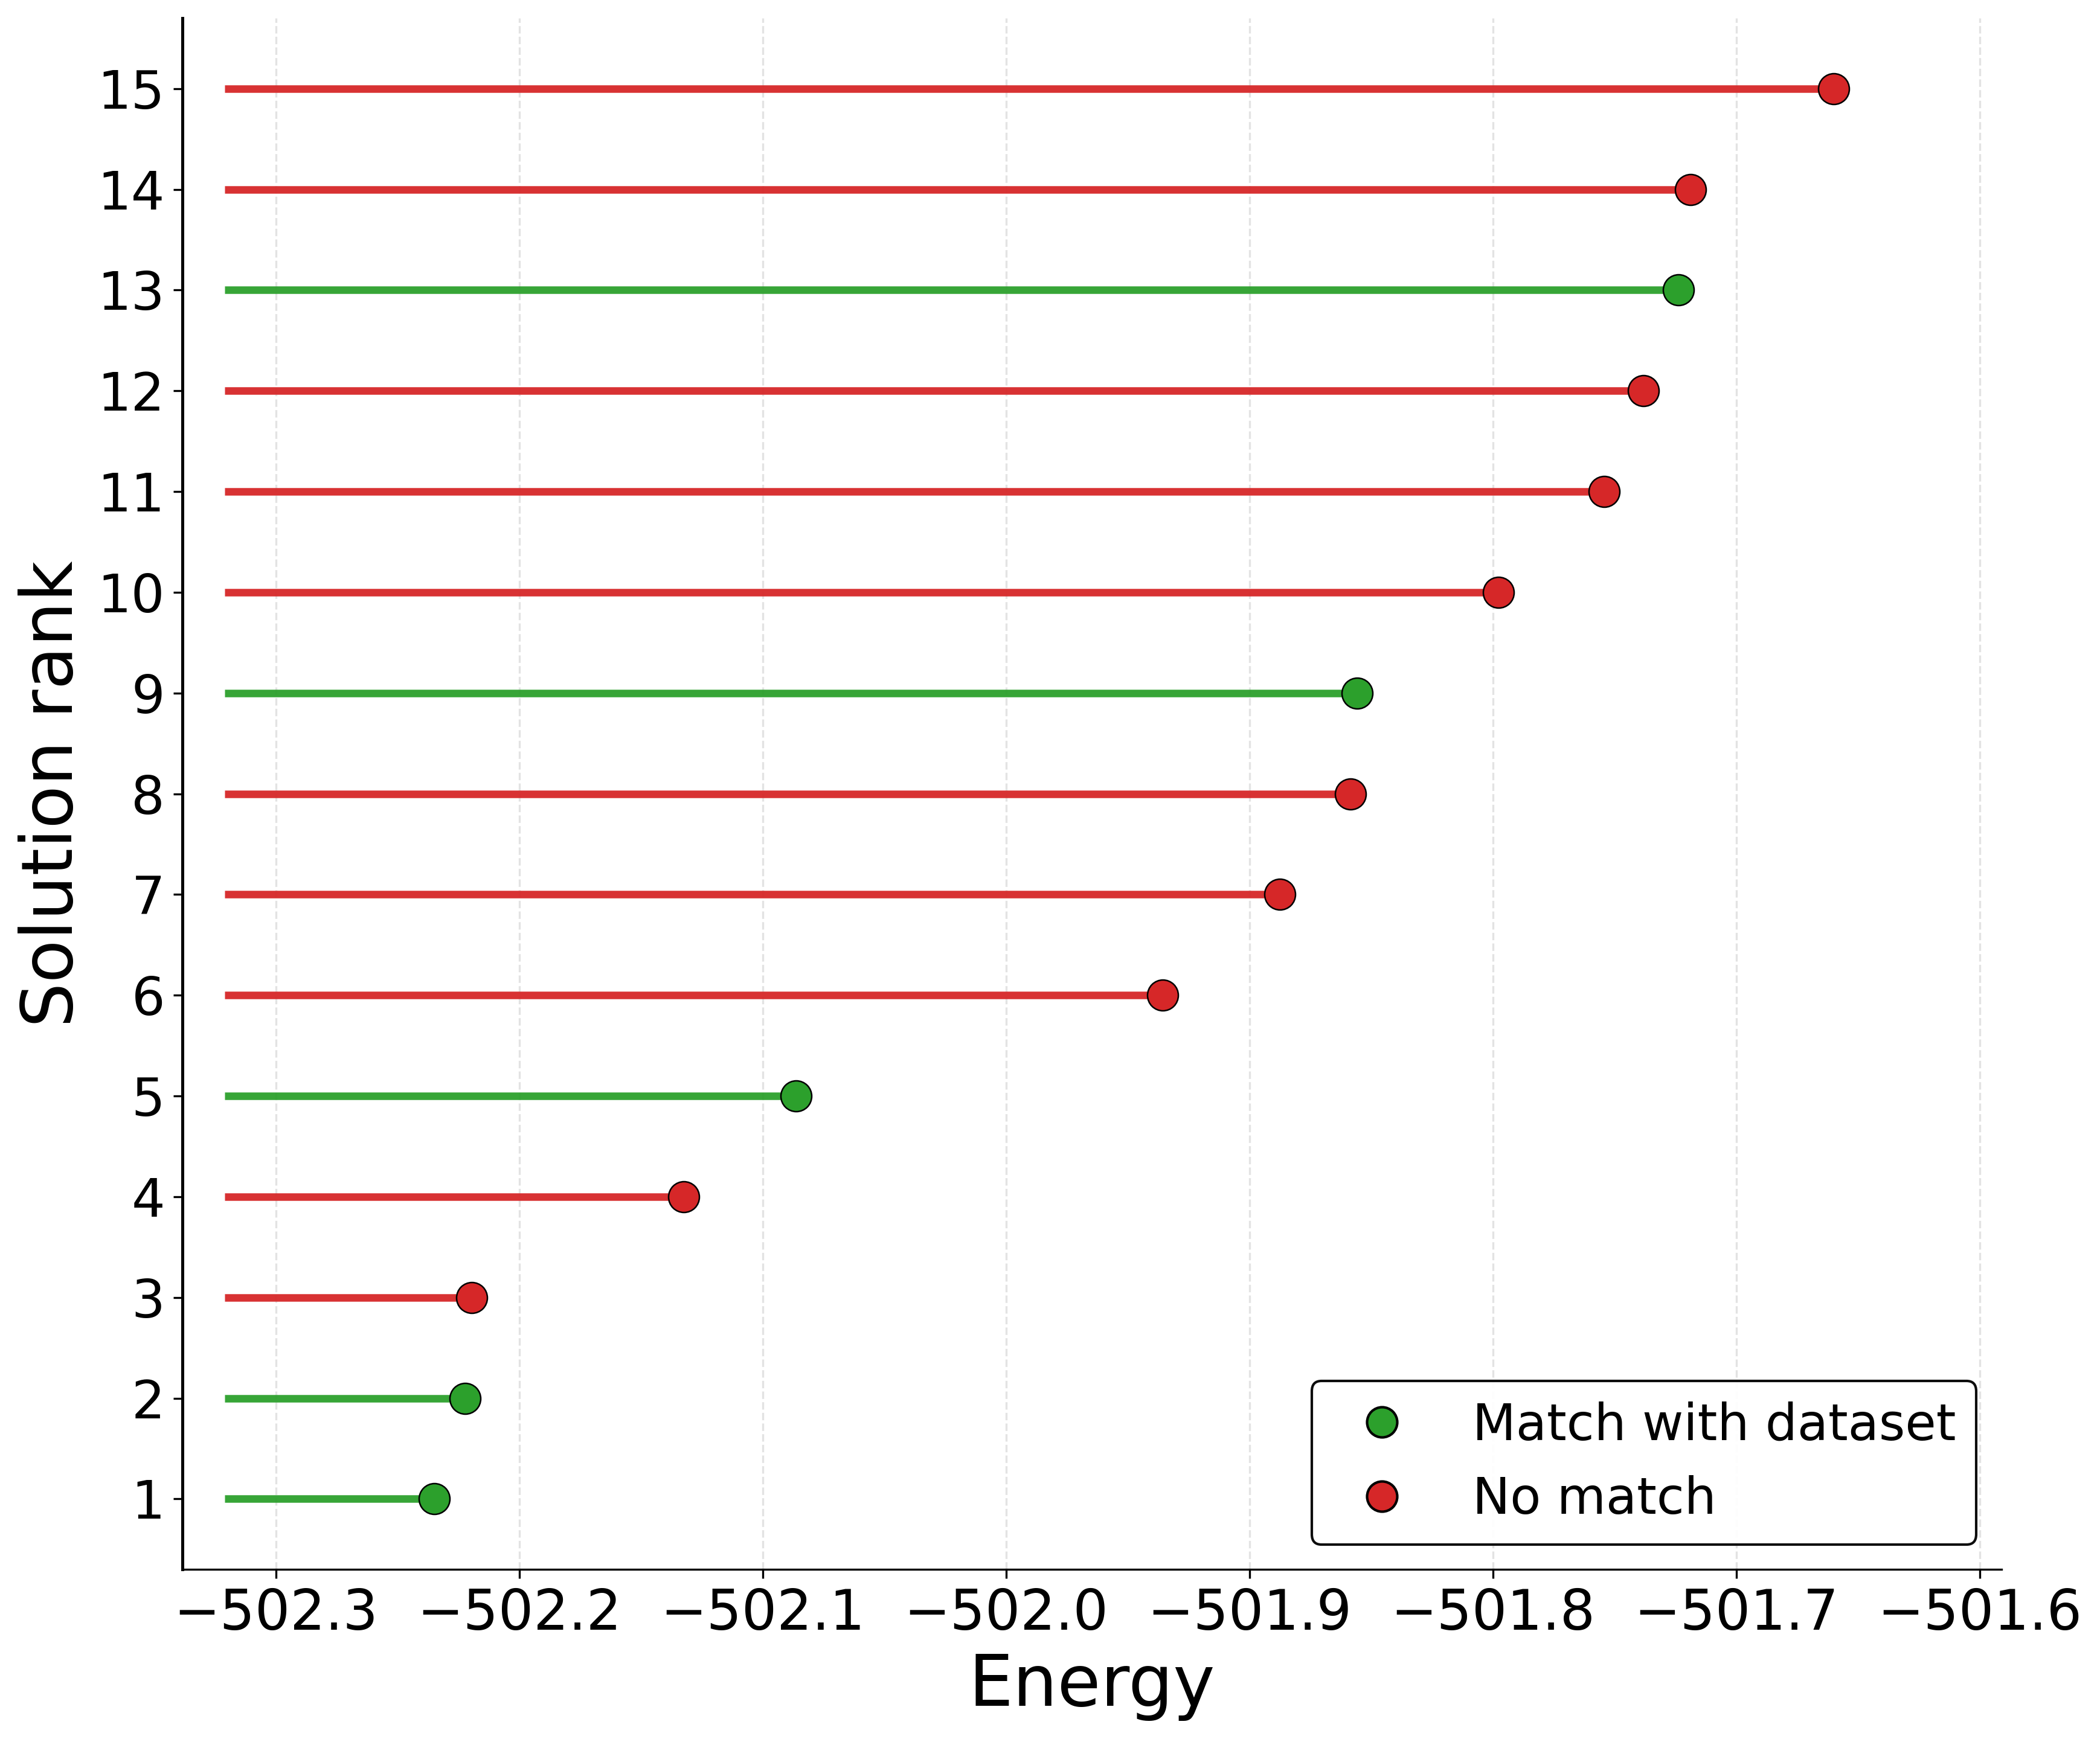

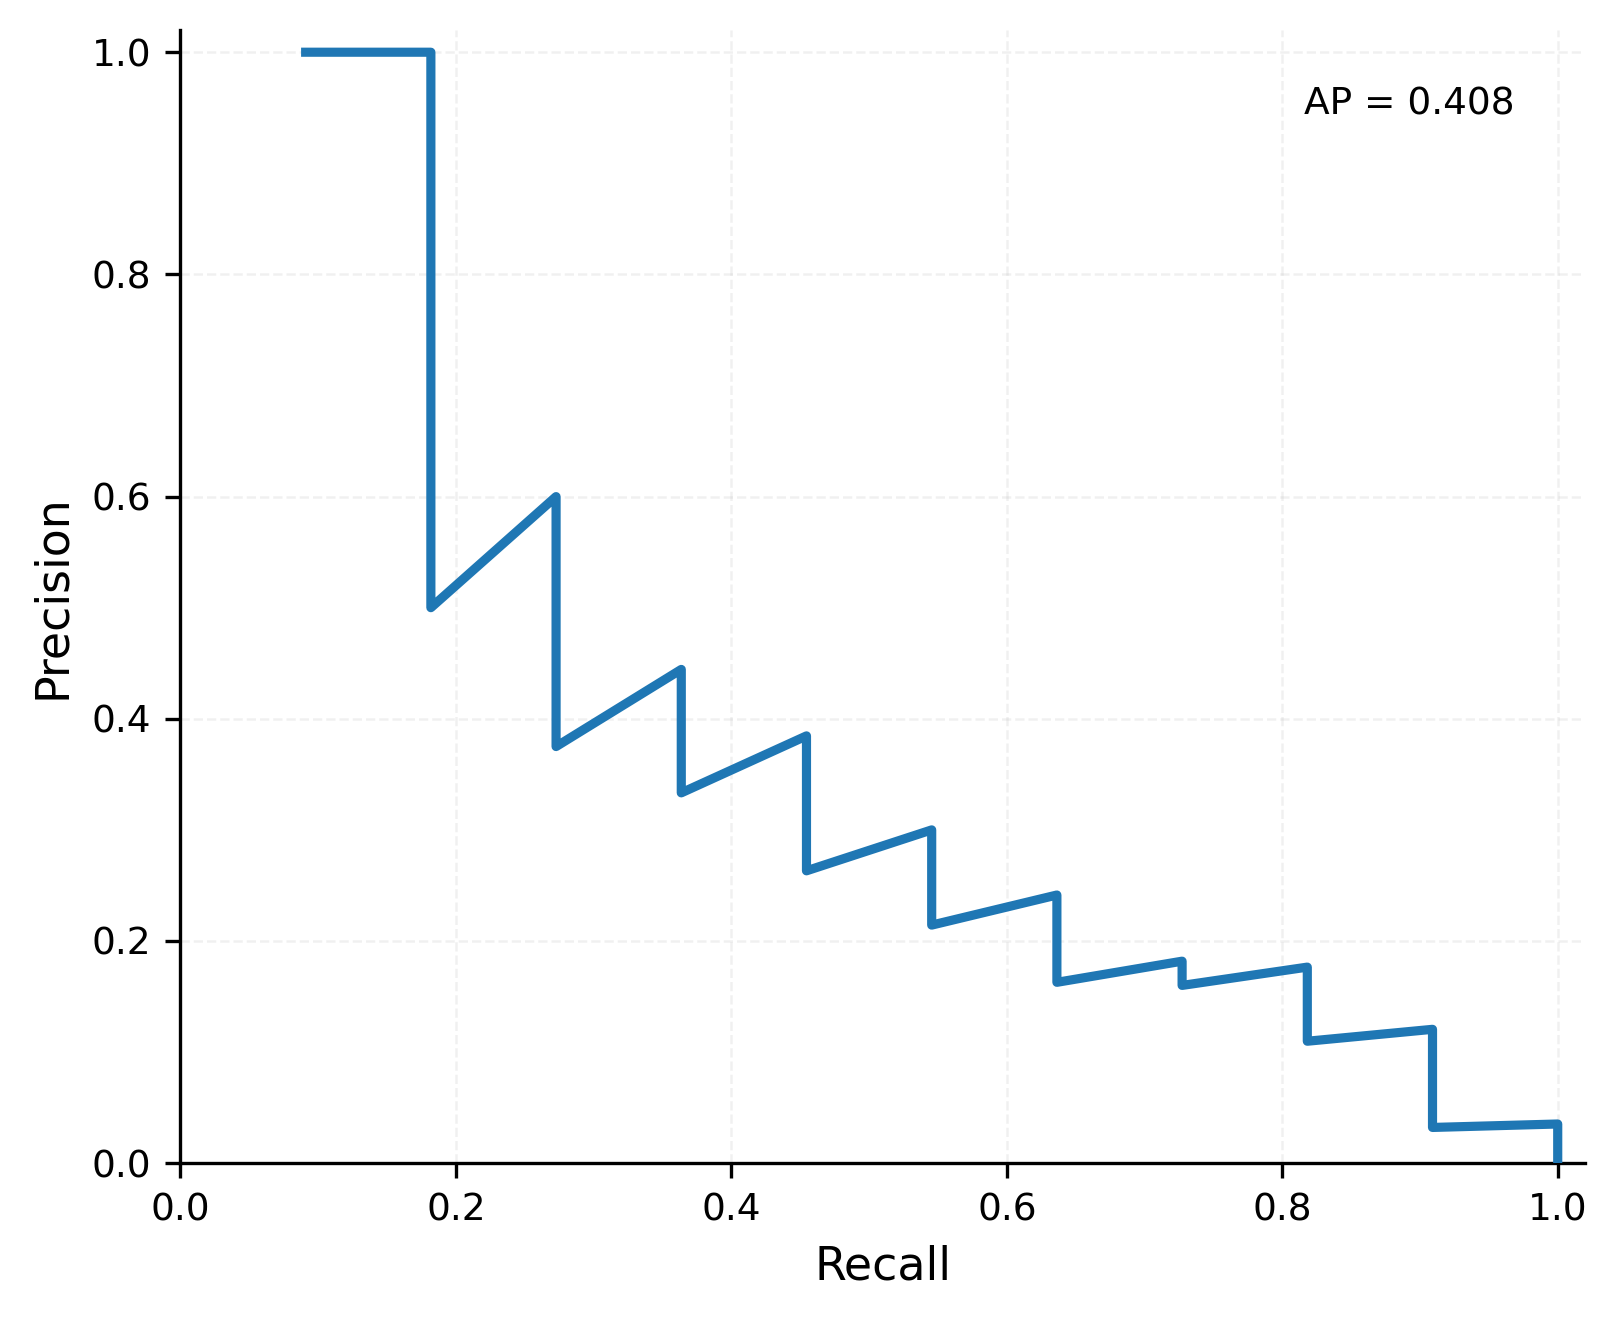

In [260]:
from qubo_selection import get_sorted_results_allowed_sizes
from parameter_optimization import plot_energy_spectrum, get_ground_truth_combinations, plot_and_compute_precision_recall_curve

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])

spectrum_50_fig = plot_energy_spectrum(sorted_results, top_n=15, disease_name=disease)

sp50_fig_path = os.path.join("Images", f"energy_spectrum_50_{disease}.pdf")

spectrum_50_fig.savefig(sp50_fig_path, format='pdf', bbox_inches="tight")

ap, precision, recall, pr_50_fig = plot_and_compute_precision_recall_curve(
    sorted_results=sorted_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)

pr_50_fig_path = os.path.join("Images", f"pr_curve_50_{disease}.pdf")
pr_50_fig.savefig(pr_50_fig_path, format="pdf", bbox_inches="tight")

In [ ]:
disease_str = disease.replace(" ", "_")

ap_qubo_file_50 = os.path.join("Results", f"best_ap_qubo_{disease}_50.json.gz")

'''
from parameter_optimization import save_qubo_to_file

save_qubo_to_file(best_qubo, ap_qubo_file_50, compress=True)
'''

from parameter_optimization import load_qubo_from_file

best_qubo_50 = load_qubo_from_file(ap_qubo_file_50)

In [334]:
from simulated_quantum_annealing import parameter_exploration

disease = 'Asthma'
enlarged_qubo = best_qubo
enlarged_drug_set = ['DB00471', 'DB00549', 'DB00588', 'DB00635', 'DB00741', 'DB00860', 'DB01234', 'DB01274', 'DB01409', 'DB00917', 'DB08393', 'DB07835', 'DB02952', 'DB00774', 'DB01242', 'DB00334', 'DB01336', 'DB00108', 'DB00805', 'DB00002', 'DB00502', 'DB01235', 'DB01267', 'DB08877', 'DB00674', 'DB00934', 'DB04006', 'DB07070', 'DB07687', 'DB01252', 'DB04868', 'DB01115', 'DB00726', 'DB03865', 'DB00661', 'DB00960', 'DB08756', 'DB08465', 'DB01243', 'DB00050', 'DB00598', 'DB08124', 'DB07502', 'DB01199', 'DB06927', 'DB05414', 'DB07715', 'DB08162', 'DB00421', 'DB01064']

gt_combinations = get_ground_truth_combinations(disease, combinations_df)

parameter_exploration(enlarged_qubo, enlarged_drug_set, gt_combinations, outdir="sqa_runs_A", top_k=10, num_reads_default=1024, repeats_per_setting=1)


Running 2 unique parameter settings, each repeated 1 times -> total runs = 2
[1] params: linear repeat 1/1 seed=1000
Sampler failed for params: {'beta_range': (0.01, 1.9), 'beta_schedule_type': 'linear', 'num_sweeps': 1, 'num_sweeps_per_beta': 2, 'Gamma': 1.0, 'num_reads': 1024} error: 'num_sweeps' must be a positive value divisible by 'num_sweeps_per_beta'.
[2] params: custom repeat 1/1 seed=1000
run=2 type=custom alpha=1.5 n_steps=20001 beta_max=3.0 spb=2 reads=1024 nsweeps=None Gamma=1.0
Saved sqa_runs_A\rankfreq_custom_n20001_alpha1.5_bmax3.0_reads1024_r1.pdf | top1_frac=0.0703 top5_frac=0.3311
All parameter runs complete. Check: sqa_runs_A


In [1]:
from dwave.samplers import PathIntegralAnnealingSampler

sampler = PathIntegralAnnealingSampler()
for kwarg in sorted(sampler.parameters):
    print(kwarg)
print("-"*14)
print("parameters:", sorted(sampler.parameters.keys()))
print("properties:", sampler.properties)

import inspect
print(inspect.getsource(sampler.sample))

beta_range
beta_schedule_type
initial_states
initial_states_generator
interrupt_function
num_reads
num_sweeps
num_sweeps_per_beta
seed
--------------
parameters: ['beta_range', 'beta_schedule_type', 'initial_states', 'initial_states_generator', 'interrupt_function', 'num_reads', 'num_sweeps', 'num_sweeps_per_beta', 'seed']
properties: {'beta_schedule_options': ('linear', 'geometric', 'custom')}
    def sample(
        self,
        bqm: dimod.BinaryQuadraticModel,
        *,
        beta_range: Optional[Union[List[float], Tuple[float, float]]] = None,
        num_reads: Optional[int] = None,
        num_sweeps: Optional[int] = None,
        num_sweeps_per_beta: int = 1,
        beta_schedule_type: str = "geometric",
        seed: Optional[int] = None,
        Hp_field: Optional[Union[Sequence[float], np.ndarray]] = None,
        Hd_field: Optional[Union[Sequence[float], np.ndarray]] = None,
        Gamma: float = 1,
        chain_coupler_strength: float = 1,
        qubits_per_chain: i